<a href="https://colab.research.google.com/github/MikelKN/WOAH-2025/blob/main/Conan_WOAH_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Loading and Set ups

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers pandas matplotlib tqdm --upgrade --quiet
!pip install cohere bertopic --quiet
!pip install -U kaleido --quiet

# import cohere
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import plotly.graph_objects as go
import random


from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from umap import UMAP
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re

from collections import Counter
import nltk
nltk.download('punkt_tab')
#must read on llm liguitic diversity: https://arxiv.org/html/2412.10271
import spacy
# !pip install bertopic
nlp = spacy.load("en_core_web_sm")
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from bertopic import BERTopic
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from google.colab import userdata
import os

import re
pd.options.display.max_colwidth = 500

!pip install --upgrade openai transformers --quiet
from openai import OpenAI

from pathlib import Path

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["OPEN_AI"] = userdata.get("OPEN_AI")
os.environ["HF_API_KEY"] = userdata.get("HF_API_KEY")
os.environ["COHERE_API"] = userdata.get("COHERE_API")

HF_TOKEN = userdata.get("HF_API_KEY")


dataset_sample = pd.read_csv('.../WOAH_2025/hateval/charts/hateeval_all_analysis_df.csv')

dataset_sample.head()

In [ ]:
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import torch.nn.functional as F
import plotly.graph_objects as go
import random

from pathlib import Path

plt.rcParams['axes.labelsize'] = 15 #set axis size globally

path = Path('.../WOAH_2025/conan/charts/march_25')

class Stats():
    def __init__ (self, colors= ['skyblue', 'orange', 'salmon', 'green', 'red', 'blue' ], figsize = (10, 6)): #text:skyblue, llama:sal, cohere:yellow, gpt:red, counter:green
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.figsize = figsize
      self.colors = colors

    def exploratory_data_analysis(self, data, text):
      # data = data.copy()  # Prevents SettingWithCopyWarning
      data[f'{text}_length'] = data[text].str.len()
      data[f'{text}_word_count'] = data[text].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
      return data

    def plot_mean_word_length(self, dataset, dataset_names, image_name):
      results_df = pd.DataFrame({
          "Dataset": [dataset_name for dataset_name in dataset_names],
          "Mean Word Length": [dataset[f'{dataset_name}_word_count'].mean() for dataset_name in dataset_names] #average words per sentence
      })

      print(results_df)
      plt.figure(figsize=self.figsize)
      plt.barh(results_df["Dataset"], results_df["Mean Word Length"], color=self.colors[:len(dataset_names)])
      plt.ylabel("dataset")
      plt.xlabel("Mean Word Length")
      plt.title("Mean Word Length Comparison")
      plt.tight_layout()
      plt.savefig(path/image_name)
      plt.show()

# docu:https://huggingface.co/SamLowe/roberta-base-go_emotions
class BERTemotion():
    def __init__(self, emotion_colors=None, max_length = 512, batch_size = 5, task ="text-classification",  sent_model_name="SamLowe/roberta-base-go_emotions"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(sent_model_name)
        self.classifier = pipeline(task="text-classification", model=sent_model_name, top_k=True, device=0 if torch.cuda.is_available() else -1)
        self.emotion_colors = {
                  "admiration": "lightblue",
                  "amusement": "yellow",
                  "anger": "red",
                  "annoyance": "orange",
                  "approval": "green",
                  "caring": "pink",
                  "confusion": "purple",
                  "curiosity": "lightgreen",
                  "desire": "magenta",
                  "disappointment": "darkblue",
                  "disapproval": "brown",
                  "disgust": "darkgreen",
                  "embarrassment": "lightcoral",
                  "excitement": "gold",
                  "fear": "black",
                  "gratitude": "turquoise",
                  "grief": "grey",
                  "joy": "lightyellow",
                  "love": "red",
                  "nervousness": "lightgrey",
                  "optimism": "lime",
                  "pride": "blue",
                  "realization": "teal",
                  "relief": "lightcyan",
                  "remorse": "darkred",
                  "sadness": "blue",
                  "surprise": "violet",
                  "neutral": "wheat"
                  }

    def predict(self, texts):
        truncated_texts = [
            self.tokenizer.decode(
                self.tokenizer(text, truncation=True, max_length=self.max_length)['input_ids'],
                skip_special_tokens=True)
            for text in texts
        ]

        # batch processing for better GPU efficiency
        model_outputs = self.classifier(truncated_texts, batch_size=self.batch_size)
        results = []
        for output in model_outputs:
            top_emotion = output[0]
            results.append({
                "emotion": top_emotion['label'],
                "emotion_score": top_emotion['score']
            })
        return results

    def random_color(self):
          return f"#{random.randint(0, 0xFFFFFF):06x}"

    def plot_emotion_distribution(self,dataset, emotion_columns, image_name, model_name, figsize=(20, 10)):
          emotion_counts = {col: dataset[col].value_counts() for col in emotion_columns}
          emotion_df = pd.DataFrame(emotion_counts).fillna(0).sort_index()
          emotion_dist = f"emotion_dict_{image_name}.png"
          emotion_df.plot(kind='barh', stacked=False, figsize=figsize, color=['green', 'blue', 'orange', 'red', 'purple'])
          plt.title(f'{model_name} emotion Labels Distribution Across Datasets')
          plt.ylabel('Emotions')
          plt.xlabel('Counts')
          plt.legend(title="Data", fontsize="20", loc='best')
          plt.savefig(path/emotion_dist)
          plt.show()

    def emotion_counts(self, data):
      return data.value_counts().to_dict()

    def create_sankey_chart(self, data, dataset_name, col_name, model_name, path=path):
        emotion_count_dict = self.emotion_counts(data)
        # all_emotions = list(emotion_count_dict.keys())
        # nodes = all_emotions + [col_name]

        top_5_emotions = sorted(emotion_count_dict.items(), key=lambda x: x[1], reverse=True)[:5]
        top_emotion_names = [emotion for emotion, _ in top_5_emotions]
        nodes = top_emotion_names + [col_name]

        node_indices = {node: idx for idx, node in enumerate(nodes)}
        links = {
            "source": [],
            "target": [],
            "value": [],
            "color": []
        }
        for emotion, count in top_5_emotions:
            links["source"].append(node_indices[emotion])
            links["target"].append(node_indices[col_name])
            links["value"].append(count)
            # links["color"].append(self.random_color())
            links['color'].append(self.emotion_colors.get(emotion.lower(), "black"))  # Default to black if emotion not found


        fig = go.Figure(go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=nodes
            ),
            link=dict(
                source=links["source"],
                target=links["target"],
                value=links["value"],
                color=links["color"]
            )
        ))
        sankey_chart = f"{dataset_name}_{model_name}_sankey_chart_for_{col_name}.png"
        fig.update_layout(title_text=f"Emotion_Flow_for {col_name}", font_size=15)
        fig.write_image(path/sankey_chart)
        fig.show()

class SentimentAnalyzer: #https://huggingface.co/tabularisai/robust-sentiment-analysis
    def __init__(self, model_name='tabularisai/robust-sentiment-analysis'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                        ).to(self.device)

    def preprocess(self, text, max_length=512):
        return self.tokenizer(text,
                              return_tensors="pt",
                              truncation=True,
                              padding=True,
                              max_length=max_length).to(self.device)

    def predict(self, text):
        inputs = self.preprocess(text)
        with torch.no_grad():
            outputs = self.model(**inputs)

        probabilities = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        sentiment_score = probabilities[0, predicted_class].item()

        sentiment_map = {0: "Very Negative",
                         1: "Negative",
                         2: "Neutral",
                         3: "Positive",
                         4: "Very Positive"}
        sentiment_output = []

        sentiment_output.append({
            "sentiment": sentiment_map[predicted_class],
            "sent_score": sentiment_score
            })
        return {"sentiment": sentiment_map[predicted_class], "sent_score": sentiment_score}

    def plot_sentiment_distribution(self,dataset, sentiment_columns, image_name, model_name, figsize=(15, 7)):
          sentiment_columns = {col: dataset[col].value_counts() for col in sentiment_columns}
          colors = {"very negative": 'red', 'negative': 'purple', 'neutral': 'gray', 'positive': 'blue', 'very positive': 'green'}
          sentiment_df = pd.DataFrame(sentiment_columns).fillna(0).sort_index()
          sentiment_df_t = sentiment_df.T
          print(sentiment_df_t)
          sentiment_dist = f"sentiment_dict_{image_name}.png"
          unique_labels = sentiment_df_t.columns.tolist()
          label_colors = [colors.get(lbl.lower(), 'black') for lbl in unique_labels]
          sentiment_df_t.plot(kind='barh', stacked=False, figsize=figsize, color=label_colors)
          sent_dist = f"sent_dict_{image_name}.png"
          plt.title(f'{model_name} sentiment Labels Distribution Across Datasets')
          plt.ylabel('models')
          plt.xlabel('Counts')
          plt.legend(title="Data", fontsize="20", loc='best')
          plt.savefig(path/sent_dist)
          plt.show()
import random
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['axes.labelsize'] = 15 #set axis font size globally

# Results with Transformers

Device set to use cuda:0






 +++++++++++++++++++ CONAN - NGOPERSONA +++++++++++++++++++++++++





 plotting word distribution conan-- ngopersona

                             Dataset  Mean Word Length
0                        HATE_SPEECH         13.223666
1                  COUNTER_NARRATIVE         24.769938
2  conan_gpt40mini_ngopersona_prompt         88.869079
3     conan_cohere_ngopersona_prompt         92.674995
4   conan_llama70b_ngopersona_prompt        106.445333


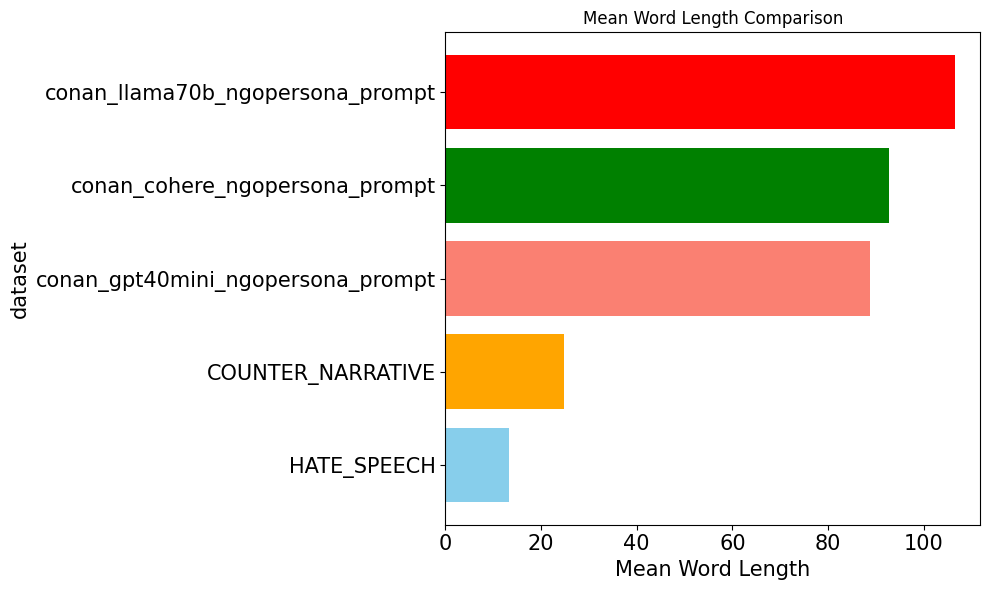


 plotting stats and emotions distribution conan-- ngopersona



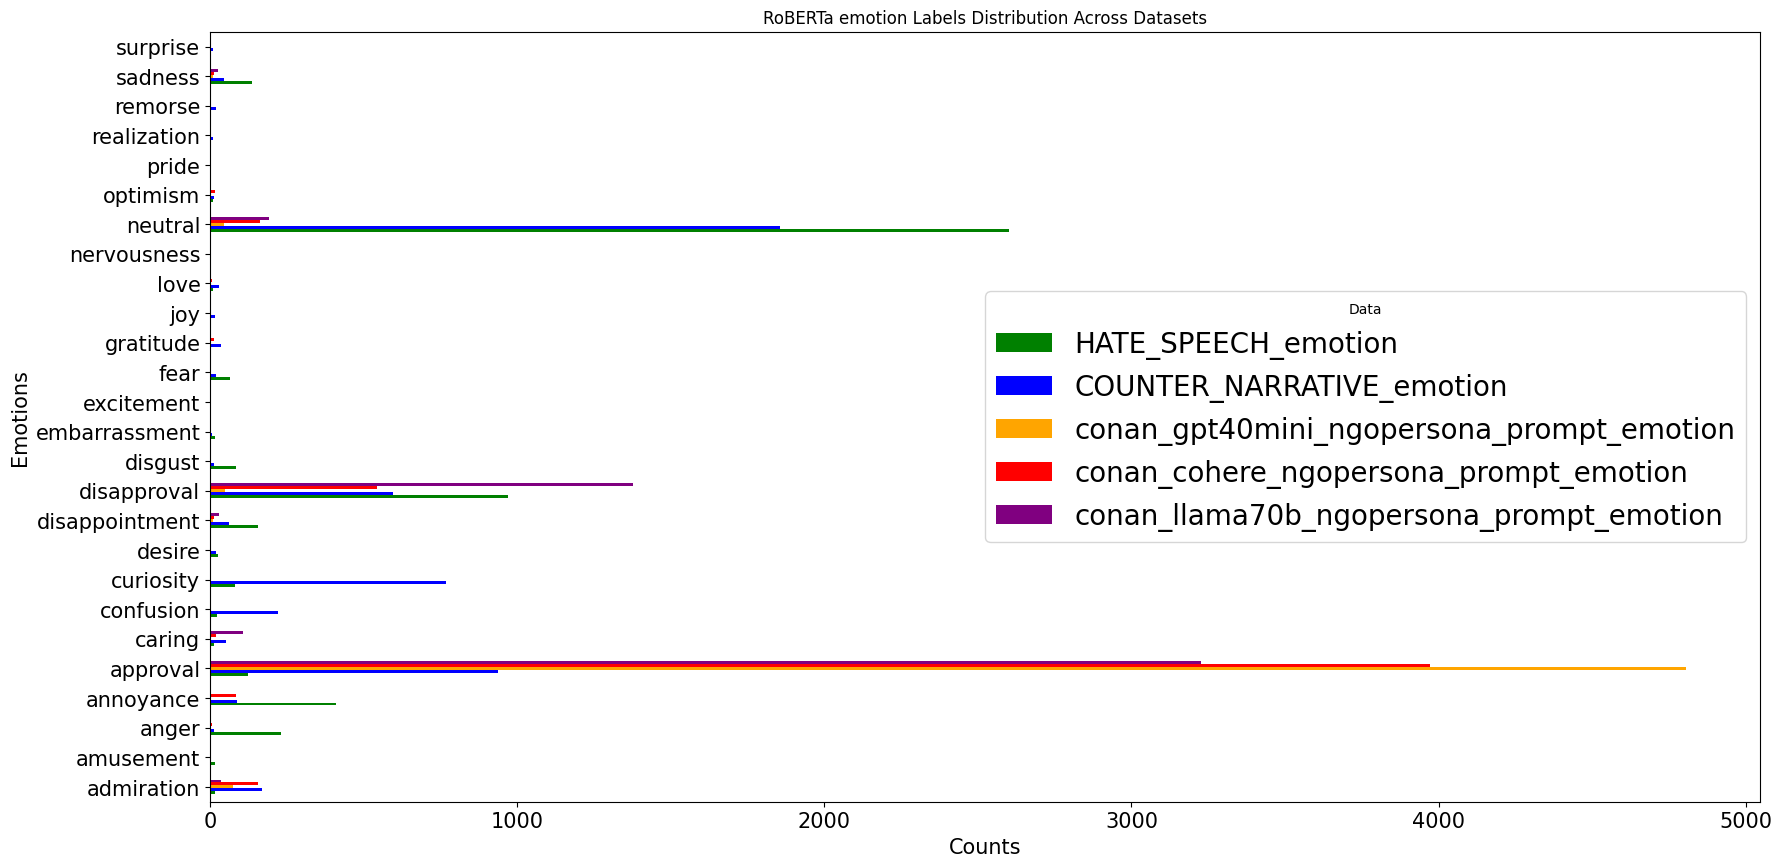

                                             Negative  Neutral  Positive  \
HATE_SPEECH_sentiment                             976      821        20   
COUNTER_NARRATIVE_sentiment                       708     2814       113   
conan_gpt40mini_ngopersona_prompt_sentiment        63     3373       124   
conan_cohere_ngopersona_prompt_sentiment           13     1816        55   
conan_llama70b_ngopersona_prompt_sentiment        122     2908       191   

                                             Very Negative  Very Positive  
HATE_SPEECH_sentiment                                 3040            146  
COUNTER_NARRATIVE_sentiment                           1109            259  
conan_gpt40mini_ngopersona_prompt_sentiment            860            583  
conan_cohere_ngopersona_prompt_sentiment              2384            735  
conan_llama70b_ngopersona_prompt_sentiment            1469            313  


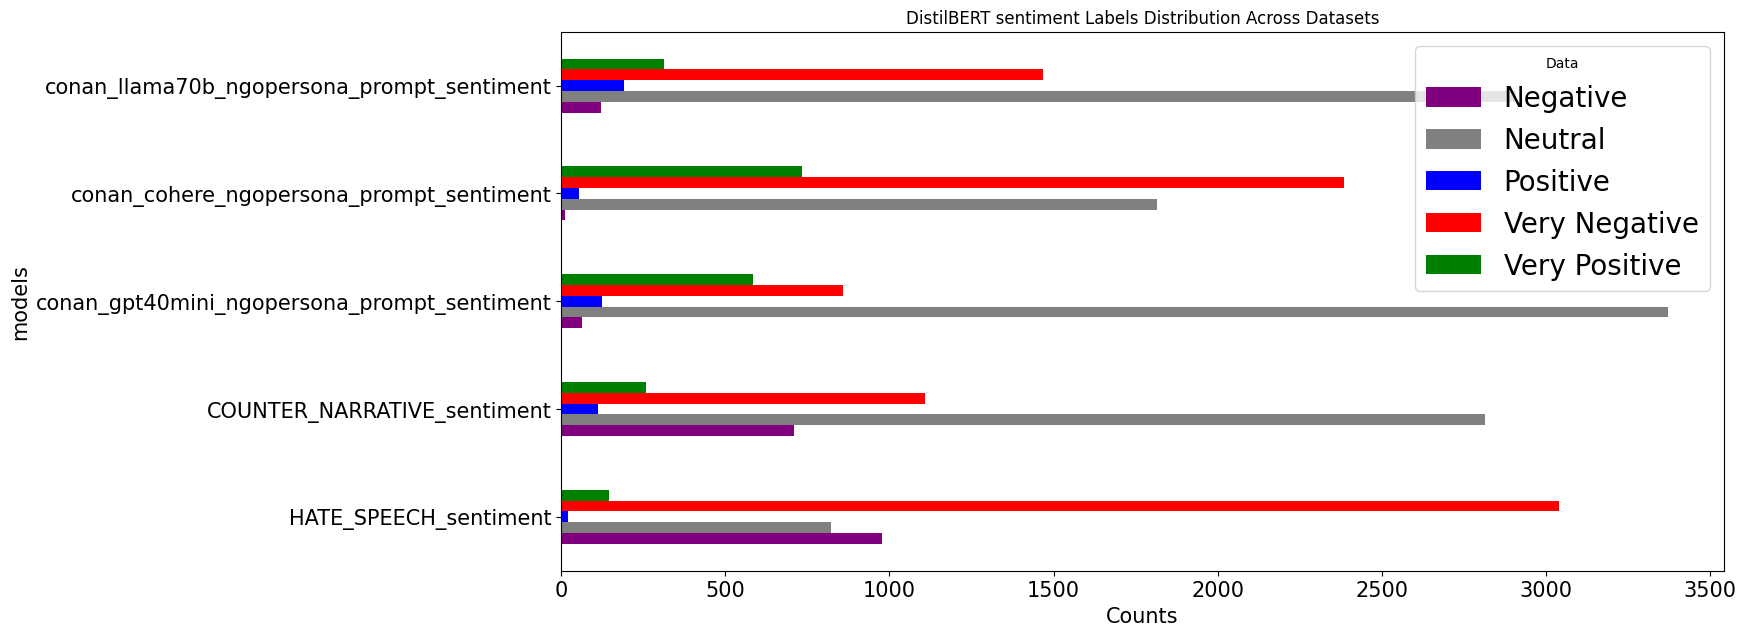


 plotting sankey charts conan--ngopersona 



Saved conan - ngopersona dataset to : /content/drive/MyDrive/PhD with Rawat/WOAH_2025/conan/charts/march_25/hate_scores/conan_ngopersona_analysis_df.csv





 +++++++++++++++++++ CONAN - NGOEMOTION +++++++++++++++++++++++++





 plotting word distribution conan-- ngoemotion

                             Dataset  Mean Word Length
0                        HATE_SPEECH         13.223666
1                  COUNTER_NARRATIVE         24.769938
2  conan_gpt40mini_ngoemotion_prompt        100.642614
3     conan_cohere_ngoemotion_prompt         98.067559
4   conan_llama70b_ngoemotion_prompt        121.788327


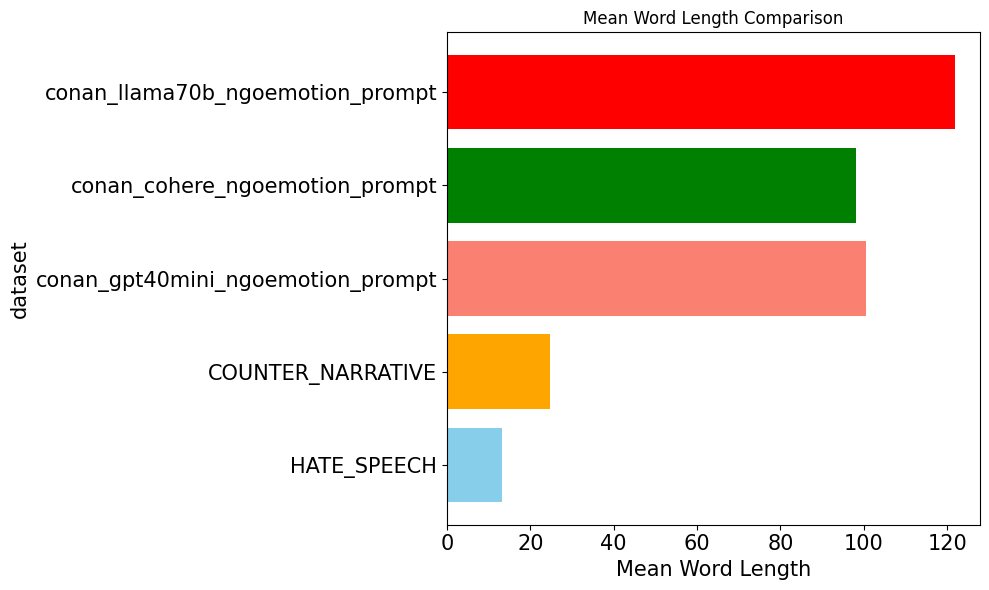


 plotting stats and emotions distribution conan-- ngoemotion



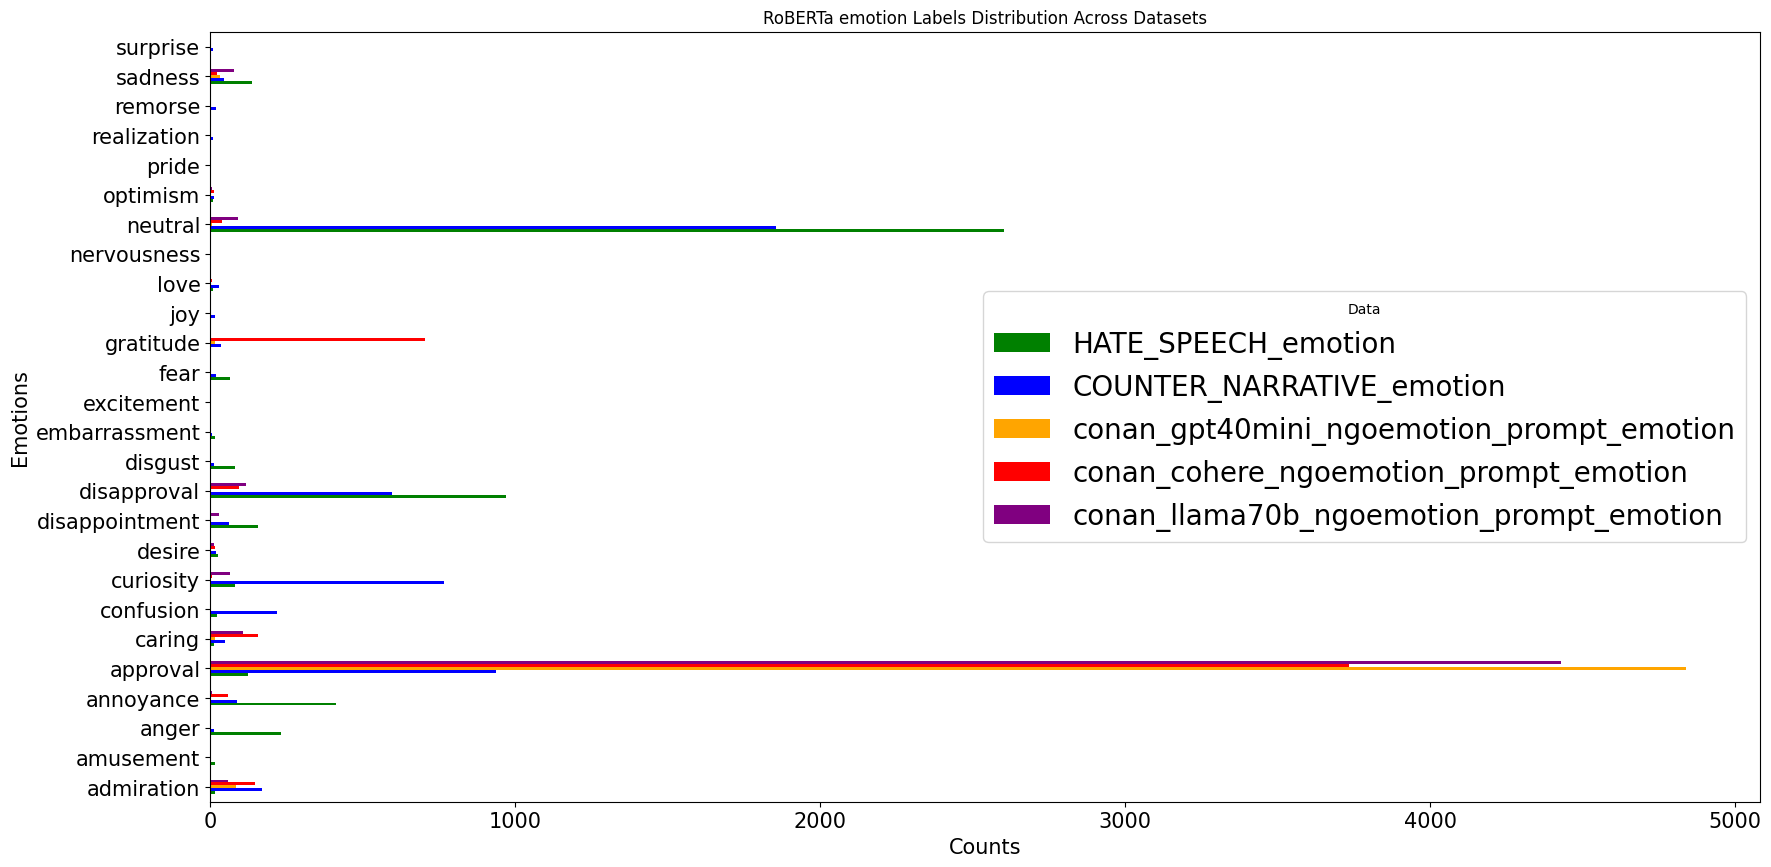

                                             Negative  Neutral  Positive  \
HATE_SPEECH_sentiment                             976      821        20   
COUNTER_NARRATIVE_sentiment                       708     2814       113   
conan_gpt40mini_ngoemotion_prompt_sentiment        22     4225       116   
conan_cohere_ngoemotion_prompt_sentiment           58     3485       127   
conan_llama70b_ngoemotion_prompt_sentiment         92     4019       323   

                                             Very Negative  Very Positive  
HATE_SPEECH_sentiment                                 3040            146  
COUNTER_NARRATIVE_sentiment                           1109            259  
conan_gpt40mini_ngoemotion_prompt_sentiment            337            303  
conan_cohere_ngoemotion_prompt_sentiment               816            517  
conan_llama70b_ngoemotion_prompt_sentiment             377            192  


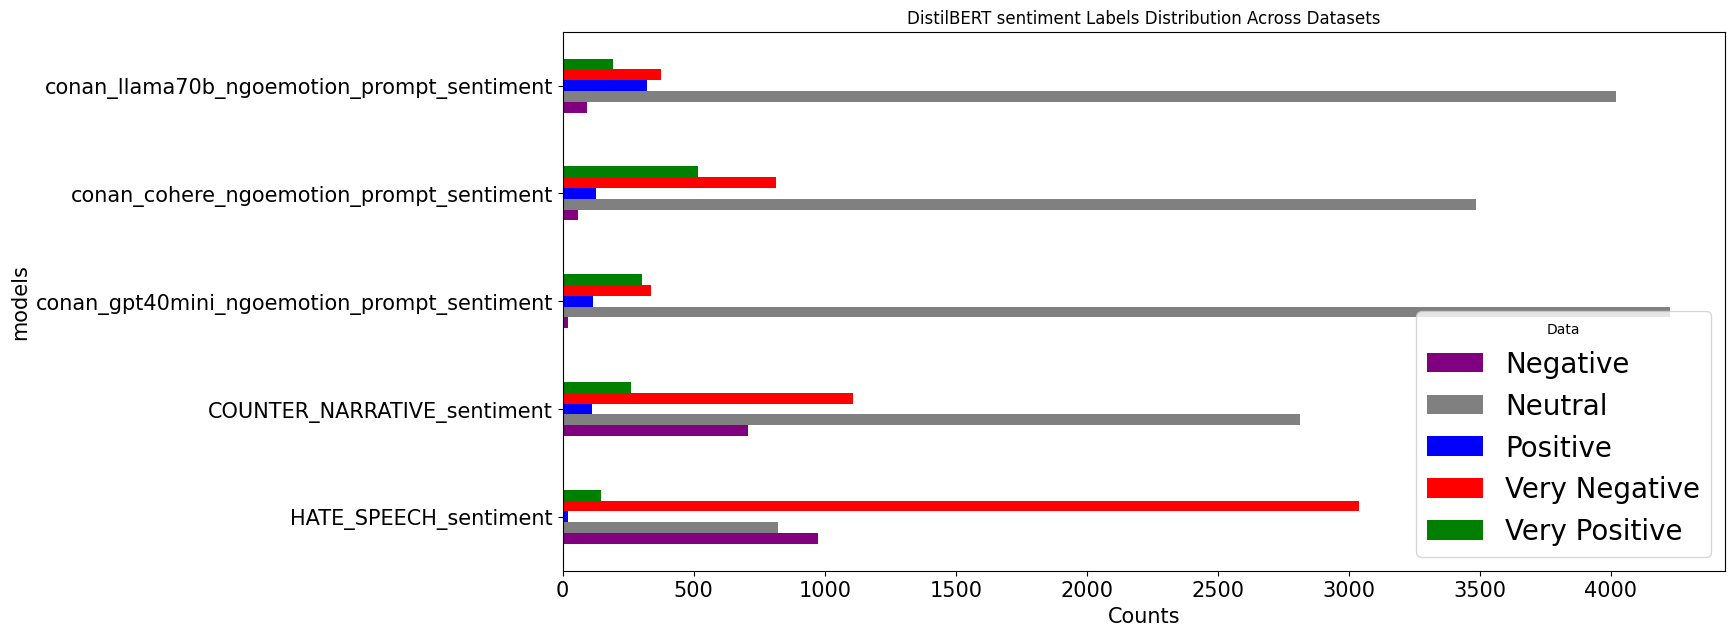


 plotting sankey charts conan--ngoemotion 



Saved conan - ngoemotion dataset to : /content/drive/MyDrive/PhD with Rawat/WOAH_2025/conan/charts/march_25/hate_scores/conan_ngoemotion_analysis_df.csv





 +++++++++++++++++++ CONAN - VANILLA +++++++++++++++++++++++++





 plotting word distribution conan-- vanilla

                          Dataset  Mean Word Length
0                     HATE_SPEECH         13.223666
1               COUNTER_NARRATIVE         24.769938
2  conan_gpt40mini_vanilla_prompt         72.220268
3     conan_cohere_vanilla_prompt         64.761943
4   conan_llama70b_vanilla_prompt         51.452129


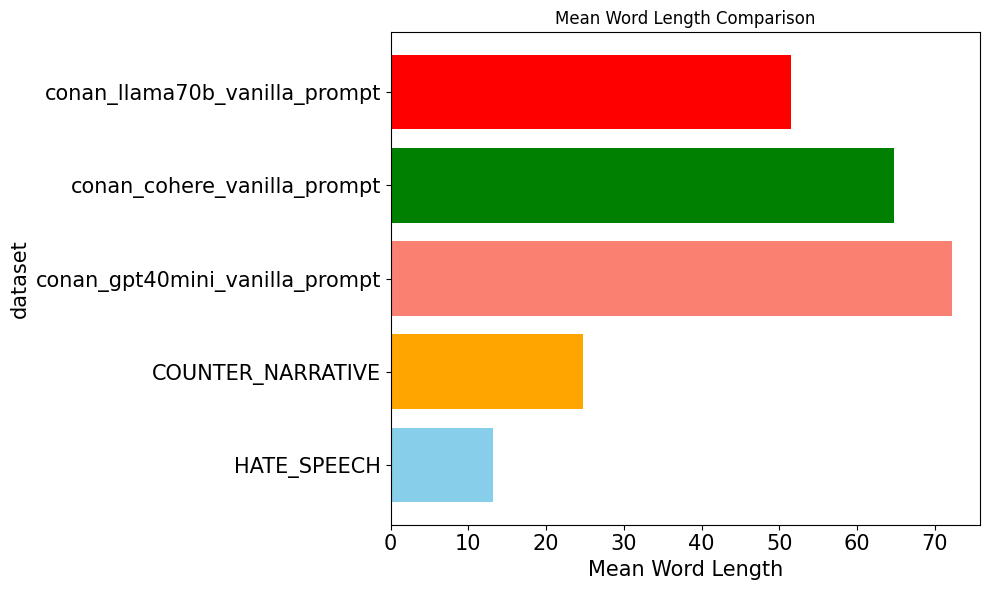


 plotting stats and emotions distribution conan-- vanilla



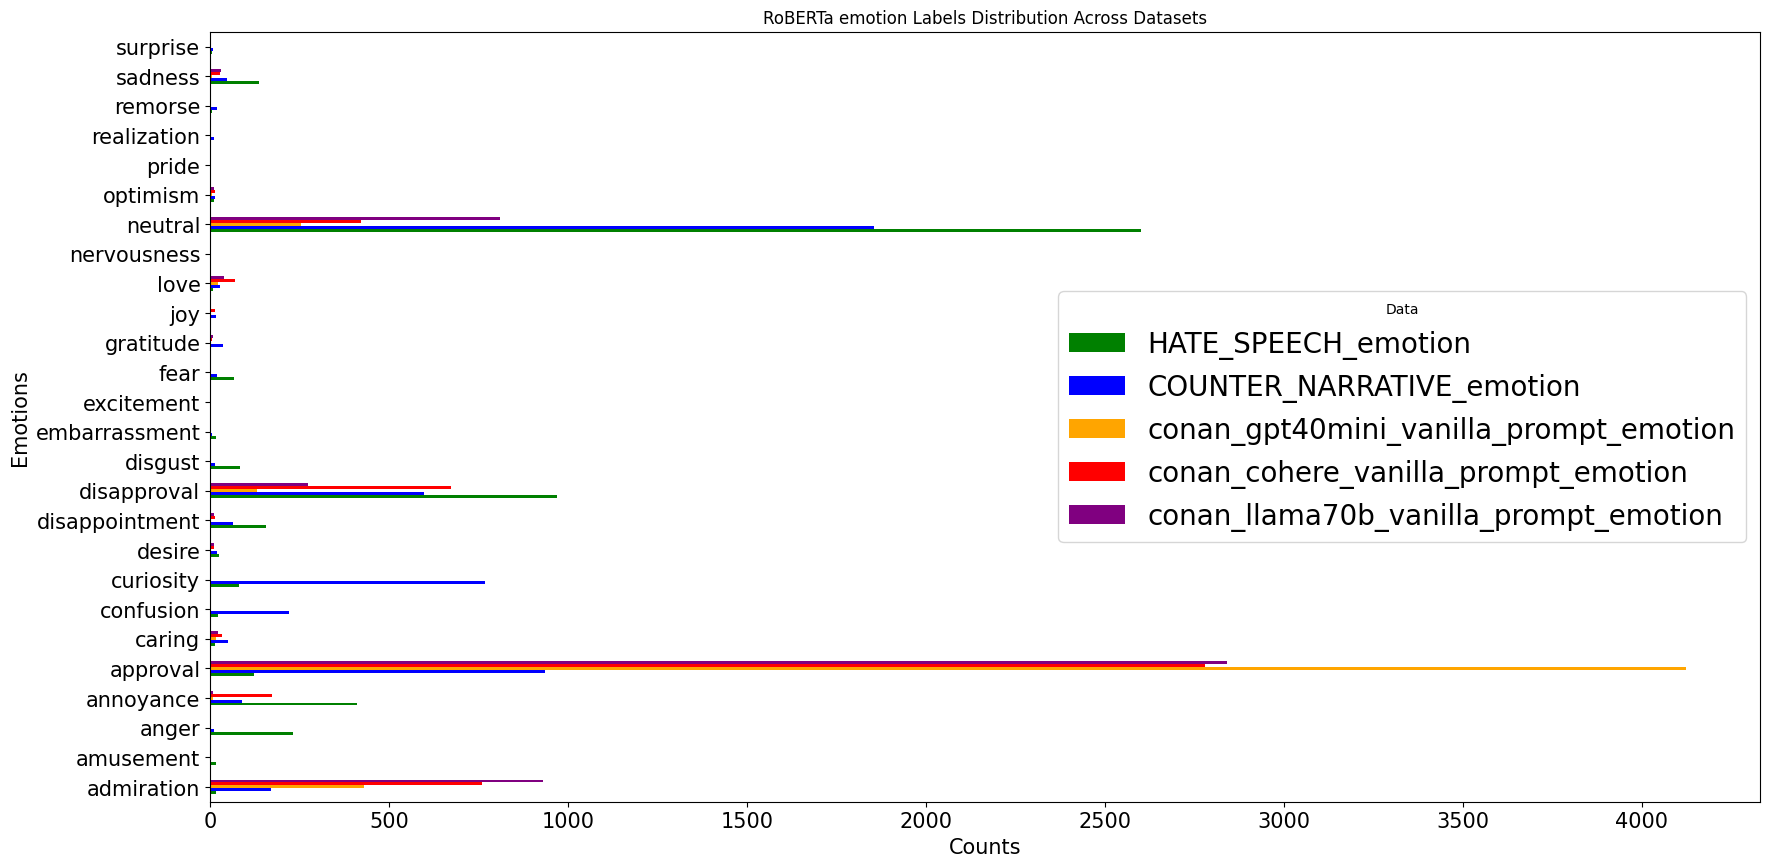

                                          Negative  Neutral  Positive  \
HATE_SPEECH_sentiment                          976      821        20   
COUNTER_NARRATIVE_sentiment                    708     2814       113   
conan_gpt40mini_vanilla_prompt_sentiment        26     2486       217   
conan_cohere_vanilla_prompt_sentiment           28     2205       187   
conan_llama70b_vanilla_prompt_sentiment         38     2577       461   

                                          Very Negative  Very Positive  
HATE_SPEECH_sentiment                              3040            146  
COUNTER_NARRATIVE_sentiment                        1109            259  
conan_gpt40mini_vanilla_prompt_sentiment            630           1644  
conan_cohere_vanilla_prompt_sentiment              1502           1081  
conan_llama70b_vanilla_prompt_sentiment             481           1446  


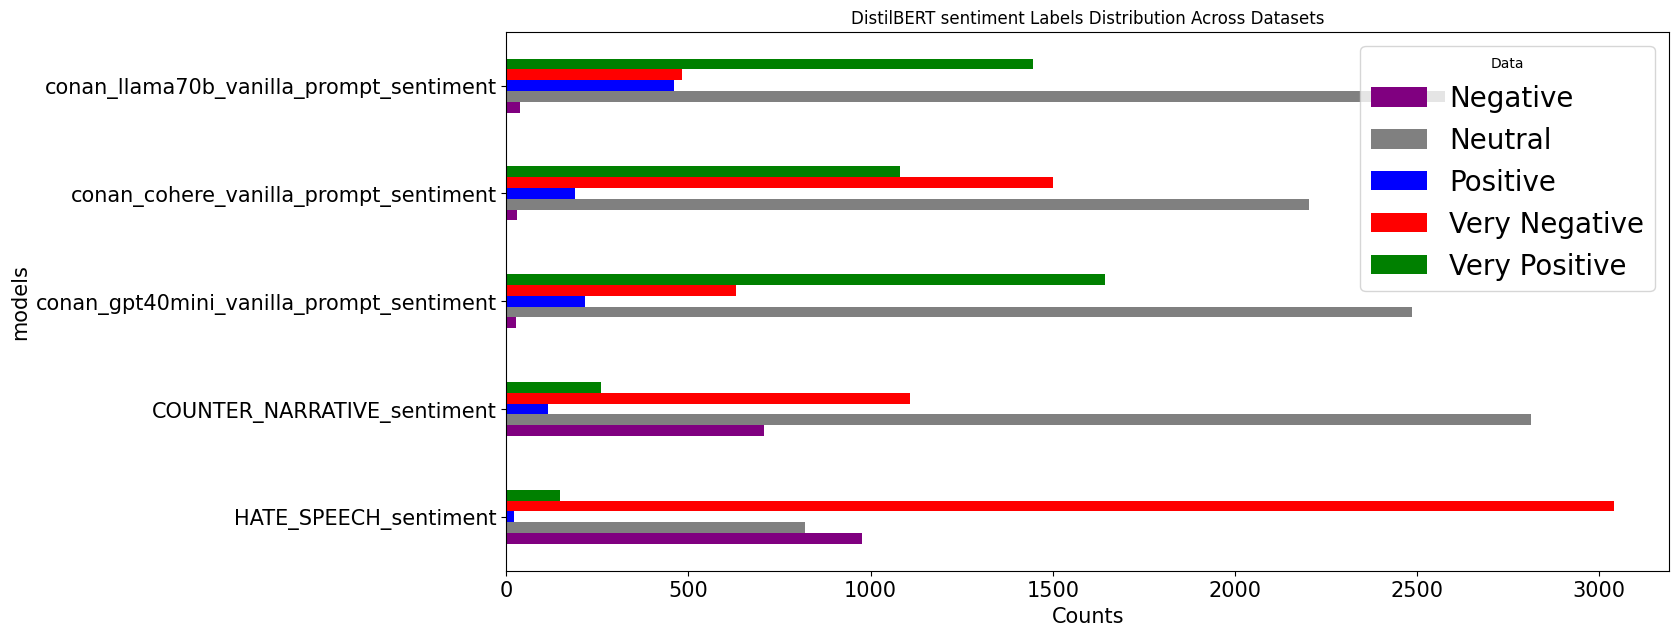


 plotting sankey charts conan--vanilla 



Saved conan - vanilla dataset to : /content/drive/MyDrive/PhD with Rawat/WOAH_2025/conan/charts/march_25/hate_scores/conan_vanilla_analysis_df.csv



In [ ]:
# c
import random
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['axes.labelsize'] = 15 #set axis font size globally
empathy_analysis = '.../WOAH_2025/conan/charts/march_25/hate_scores'
if __name__ == "__main__":
    emotion = BERTemotion()
    stats = Stats()
    sentiment = SentimentAnalyzer()
    conan_df = pd.read_csv('.../WOAH_2025/conan/nonan_conan_all_prompt_mistral_sent_emot.csv')
    conan_vanilla = [col for col in conan_df.columns if col.endswith(("vanilla_prompt", 'vanilla_sentiment_mistral', 'vanilla_emotion_mistral'))]
    conan_ngoperson = [col for col in conan_df.columns if col.endswith(("ngopersona_prompt", 'ngopersona_sentiment_mistral', 'ngopersona_emotion_mistral'))]
    conan_ngowithemotion = [col for col in conan_df.columns if col.endswith(("ngoemotion_prompt", 'ngoemotion_sentiment_mistral', 'ngoemotion_emotion_mistral'))]

    dataset_cases = [('conan', conan_df)] # ('hateval, hateeval_df)
    models = ['gpt40mini', 'cohere', 'llama70b']
    personae = ['ngopersona', 'ngoemotion','vanilla']


    for persona in personae:
        for dataset_name, dataset in dataset_cases:
            print(f"\n\n\n\n +++++++++++++++++++ {dataset_name.upper()} - {persona.upper()} +++++++++++++++++++++++++\n\n\n\n")
            expected_cols = ['text', 'HATE_SPEECH', 'COUNTER_NARRATIVE',
                             f'{dataset_name}_gpt40mini_{persona}_prompt',
                             f'{dataset_name}_cohere_{persona}_prompt',
                             f'{dataset_name}_llama70b_{persona}_prompt']
            col_names = [col for col in expected_cols if col in dataset.columns]
            # dataset = dataset[col_names].sample(n=3, random_state=42)
            dataset = dataset[col_names]
            emotion_columns = []
            sentiment_columns = []
            for item in col_names:
                stats.exploratory_data_analysis(dataset,item)
                dataset_emotion = emotion.predict(dataset[item].tolist())
                dataset[f"{item}_emotion"] = [result['emotion'] for result in dataset_emotion]
                dataset[f"{item}_score"] = [result['emotion_score'] for result in dataset_emotion]
                emotion_columns.append(f"{item}_emotion")

                 # Apply sentiment analysis to each row
                dataset[f"{item}_sentiment"], dataset[f"{item}_sentiment_score"] = zip(*dataset[item].apply(lambda x: sentiment.predict(x).values()))
                sentiment_columns.append(f"{item}_sentiment")

            print(f"\n plotting word distribution {dataset_name}-- {persona}\n")
            stats.plot_mean_word_length(dataset, col_names, f'{dataset_name}_mean_word_distr_hateeval_{persona}')
            print(f"\n plotting stats and emotions distribution {dataset_name}-- {persona}\n")
            emotion.plot_emotion_distribution(dataset, emotion_columns=emotion_columns, model_name='RoBERTa',image_name =f'{dataset_name}_emotion_distr_{dataset_name}_{persona}')

            # Plot sentiment distribution
            sentiment.plot_sentiment_distribution(dataset, sentiment_columns=sentiment_columns,model_name='DistilBERT', image_name="sentiment_results")

            print(f"\n plotting sankey charts {dataset_name}--{persona} \n")
            for col in col_names:
                emotion.create_sankey_chart(dataset[f"{col}_emotion"], dataset_name, col, model_name='RoBERTa', path=path)
        file_name = f'{dataset_name}_{persona}_analysis_df.csv'
        file_path = os.path.join(empathy_analysis, file_name)
        dataset.to_csv(file_path, index=False)
        print(f"Saved {dataset_name} - {persona} dataset to : {file_path}\n")


# TESTING ON THE MISTRAL EMOTIONS AND SENTIMENTS

Device set to use cpu






 +++++++++++++++++++ CONAN - NGOPERSONA +++++++++++++++++++++++++





 plotting stats and emotions distribution for conan-- ngopersona



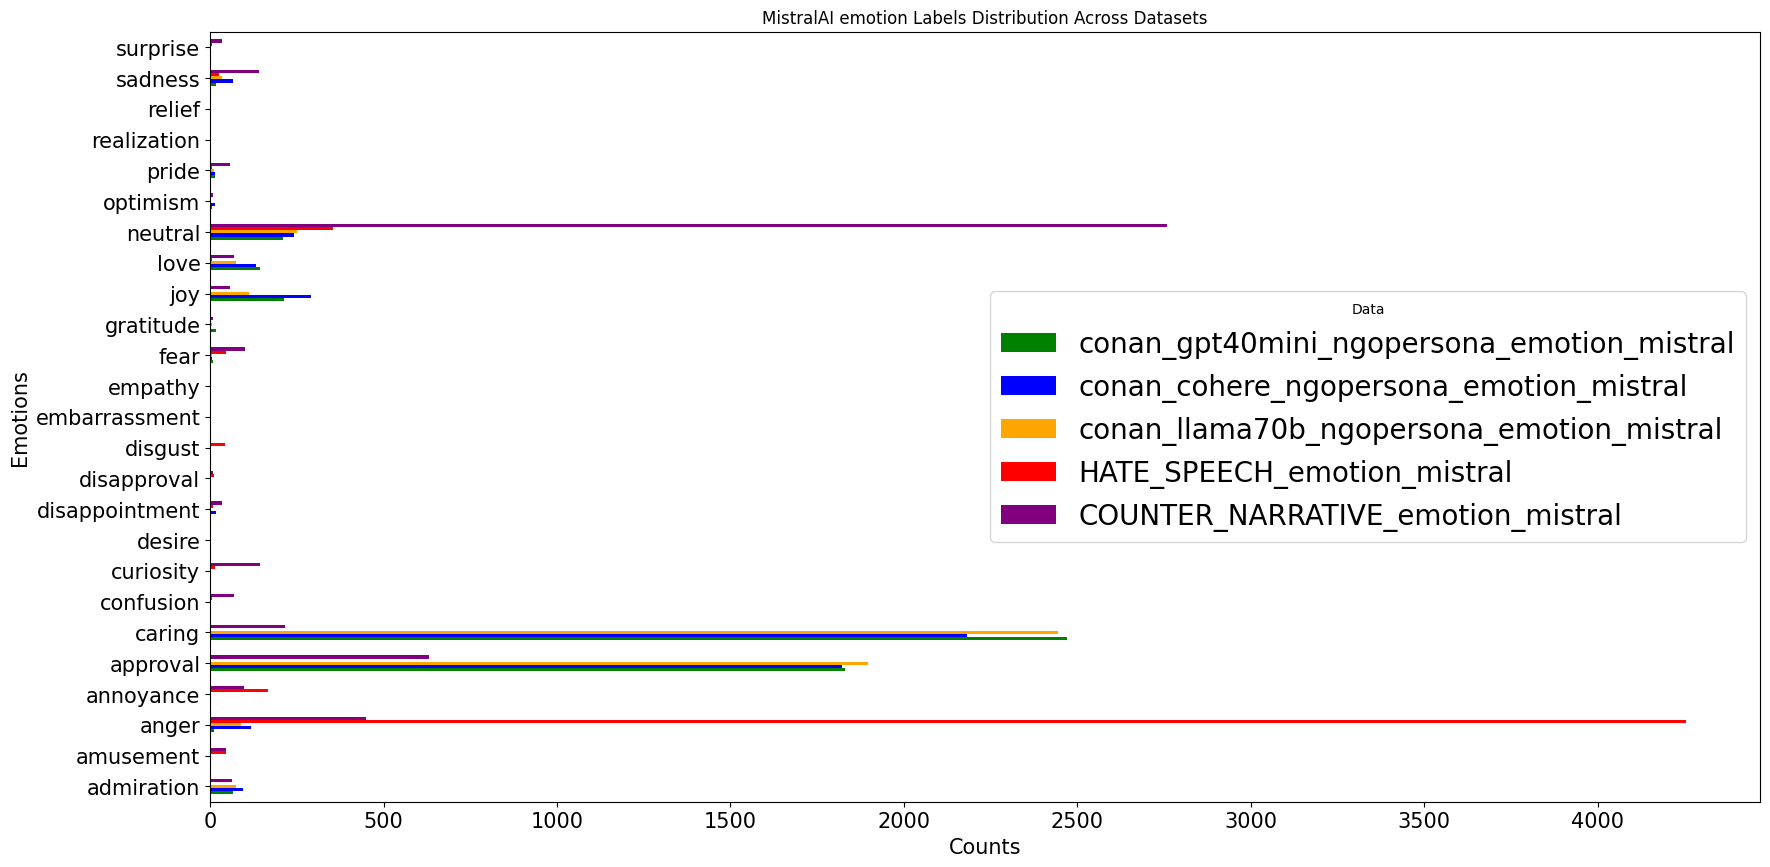

                                              negative  neutral  positive  \
conan_gpt40mini_ngopersona_sentiment_mistral      35.0     61.0    4880.0   
conan_cohere_ngopersona_sentiment_mistral        286.0     51.0    4461.0   
conan_llama70b_ngopersona_sentiment_mistral      282.0     93.0    4558.0   
HATE_SPEECH_sentiment_mistral                    835.0    141.0      17.0   
COUNTER_NARRATIVE_sentiment_mistral             1037.0   2043.0    1657.0   

                                              very negative  very positive  
conan_gpt40mini_ngopersona_sentiment_mistral           27.0            0.0  
conan_cohere_ngopersona_sentiment_mistral             202.0            3.0  
conan_llama70b_ngopersona_sentiment_mistral            70.0            0.0  
HATE_SPEECH_sentiment_mistral                        4010.0            0.0  
COUNTER_NARRATIVE_sentiment_mistral                   266.0            0.0  


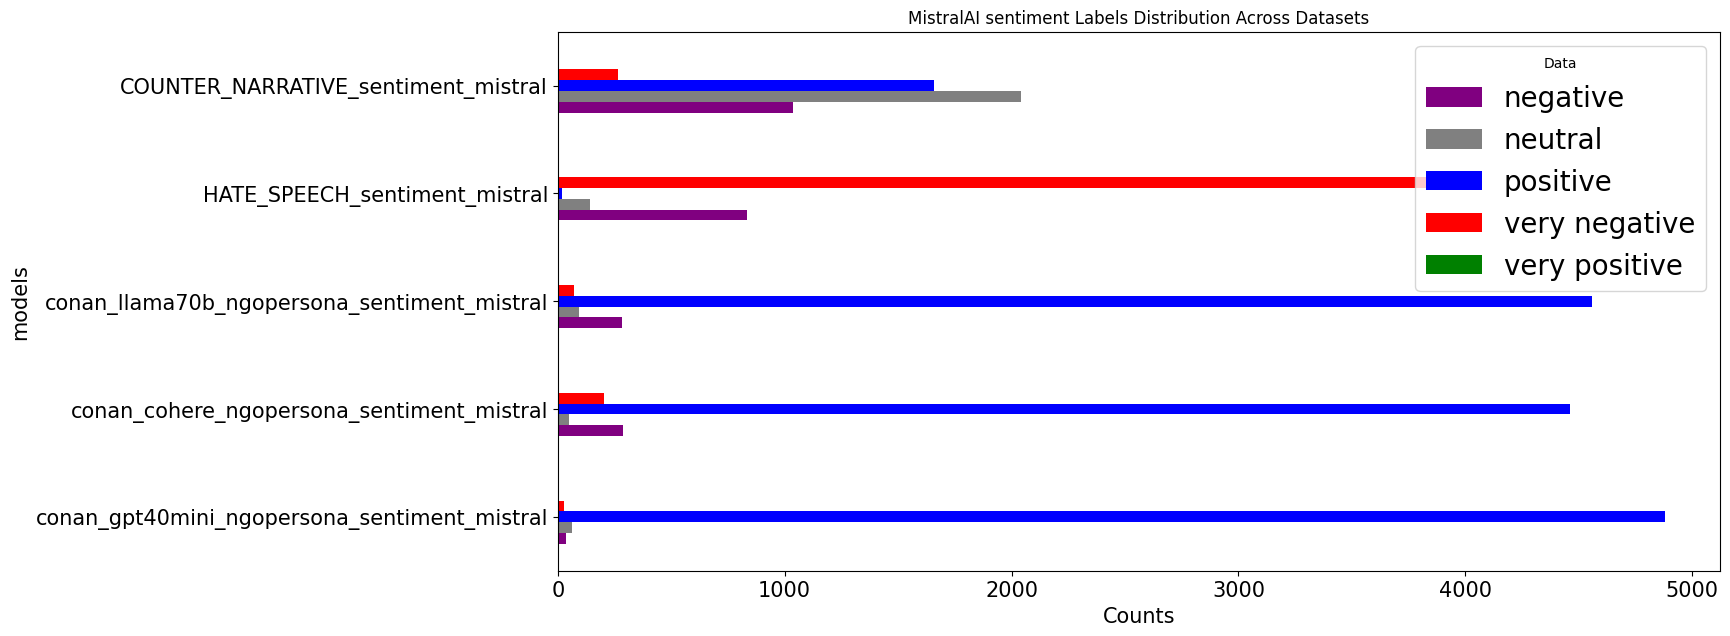


 plotting sankey charts conan-- ngopersona







 +++++++++++++++++++ CONAN - VANILLA +++++++++++++++++++++++++





 plotting stats and emotions distribution for conan-- vanilla



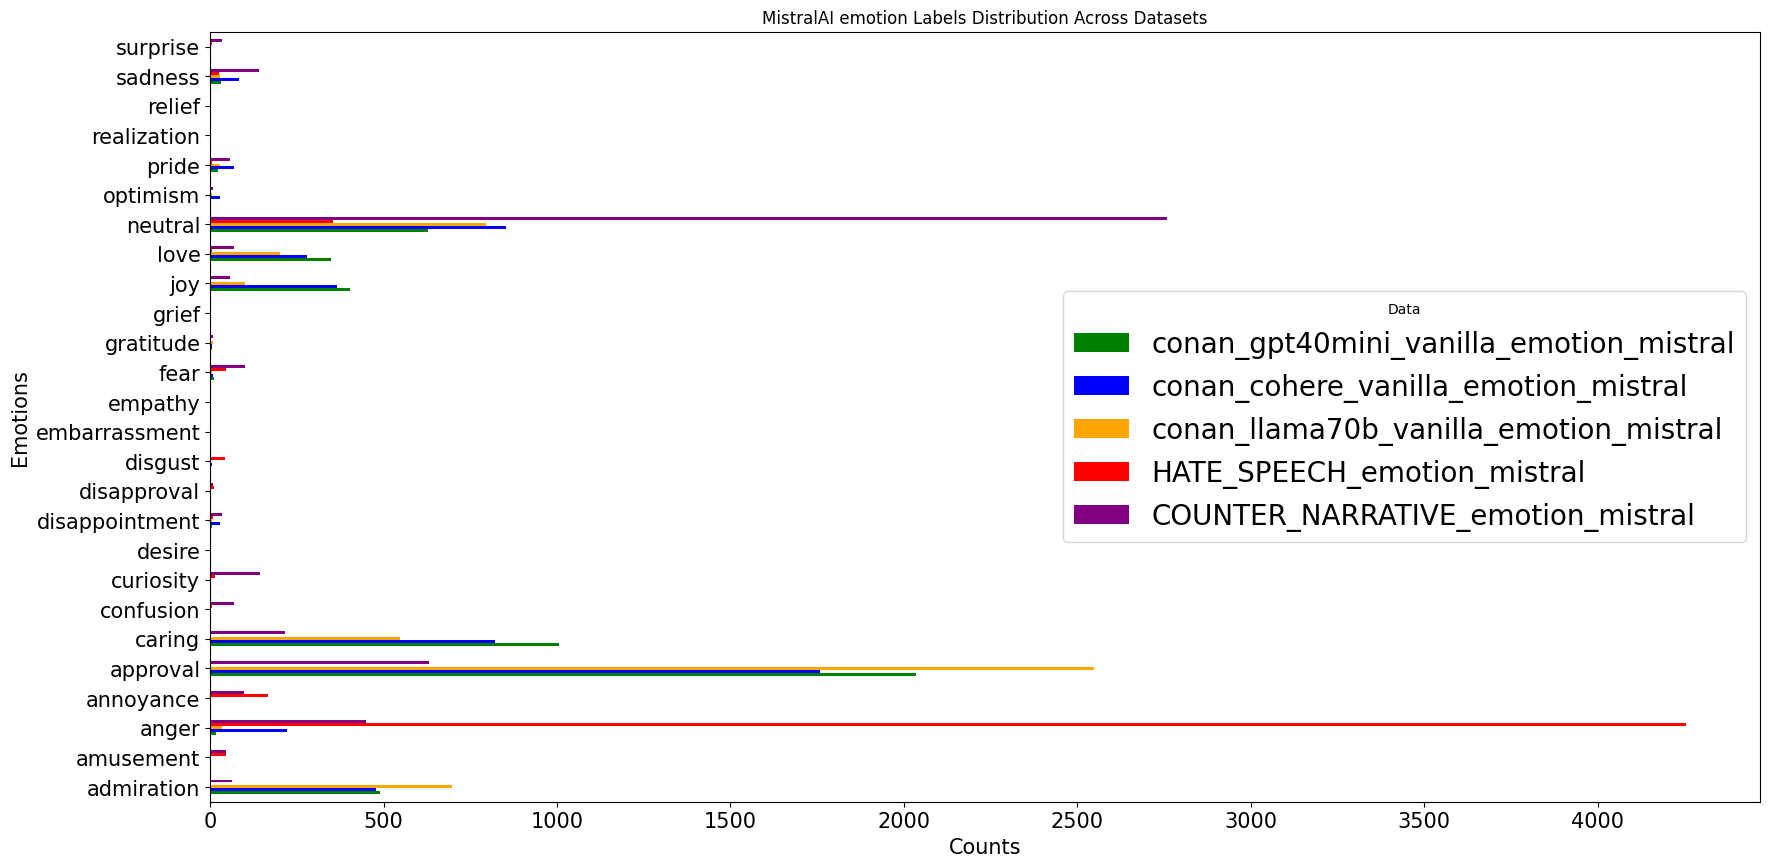

                                           negative  neutral  positive  \
conan_gpt40mini_vanilla_sentiment_mistral      89.0    119.0    4779.0   
conan_cohere_vanilla_sentiment_mistral        350.0    259.0    4077.0   
conan_llama70b_vanilla_sentiment_mistral      103.0    177.0    4699.0   
HATE_SPEECH_sentiment_mistral                 835.0    141.0      17.0   
COUNTER_NARRATIVE_sentiment_mistral          1037.0   2043.0    1657.0   

                                           very negative  very positive  
conan_gpt40mini_vanilla_sentiment_mistral           16.0            0.0  
conan_cohere_vanilla_sentiment_mistral             316.0            1.0  
conan_llama70b_vanilla_sentiment_mistral            24.0            0.0  
HATE_SPEECH_sentiment_mistral                     4010.0            0.0  
COUNTER_NARRATIVE_sentiment_mistral                266.0            0.0  


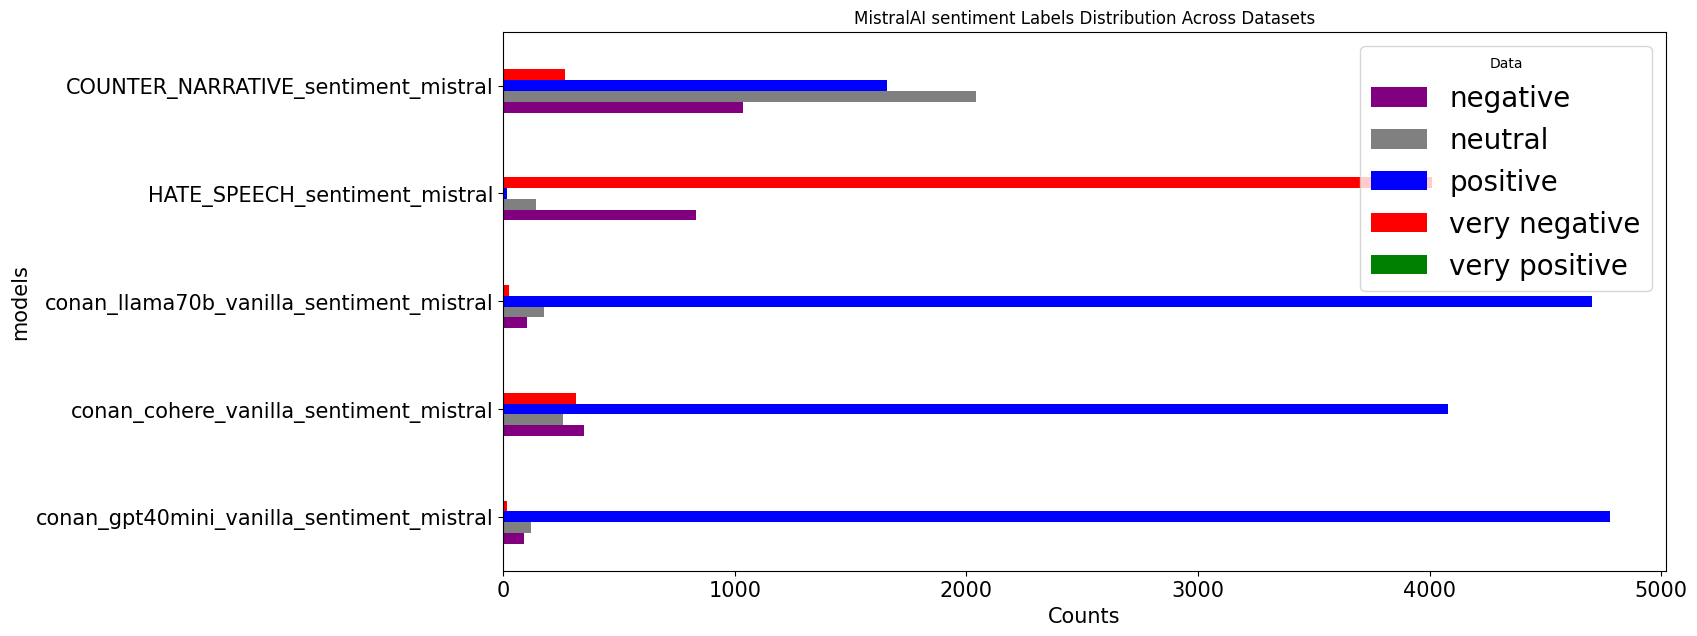


 plotting sankey charts conan-- vanilla







 +++++++++++++++++++ CONAN - NGOEMOTION +++++++++++++++++++++++++





 plotting stats and emotions distribution for conan-- ngoemotion



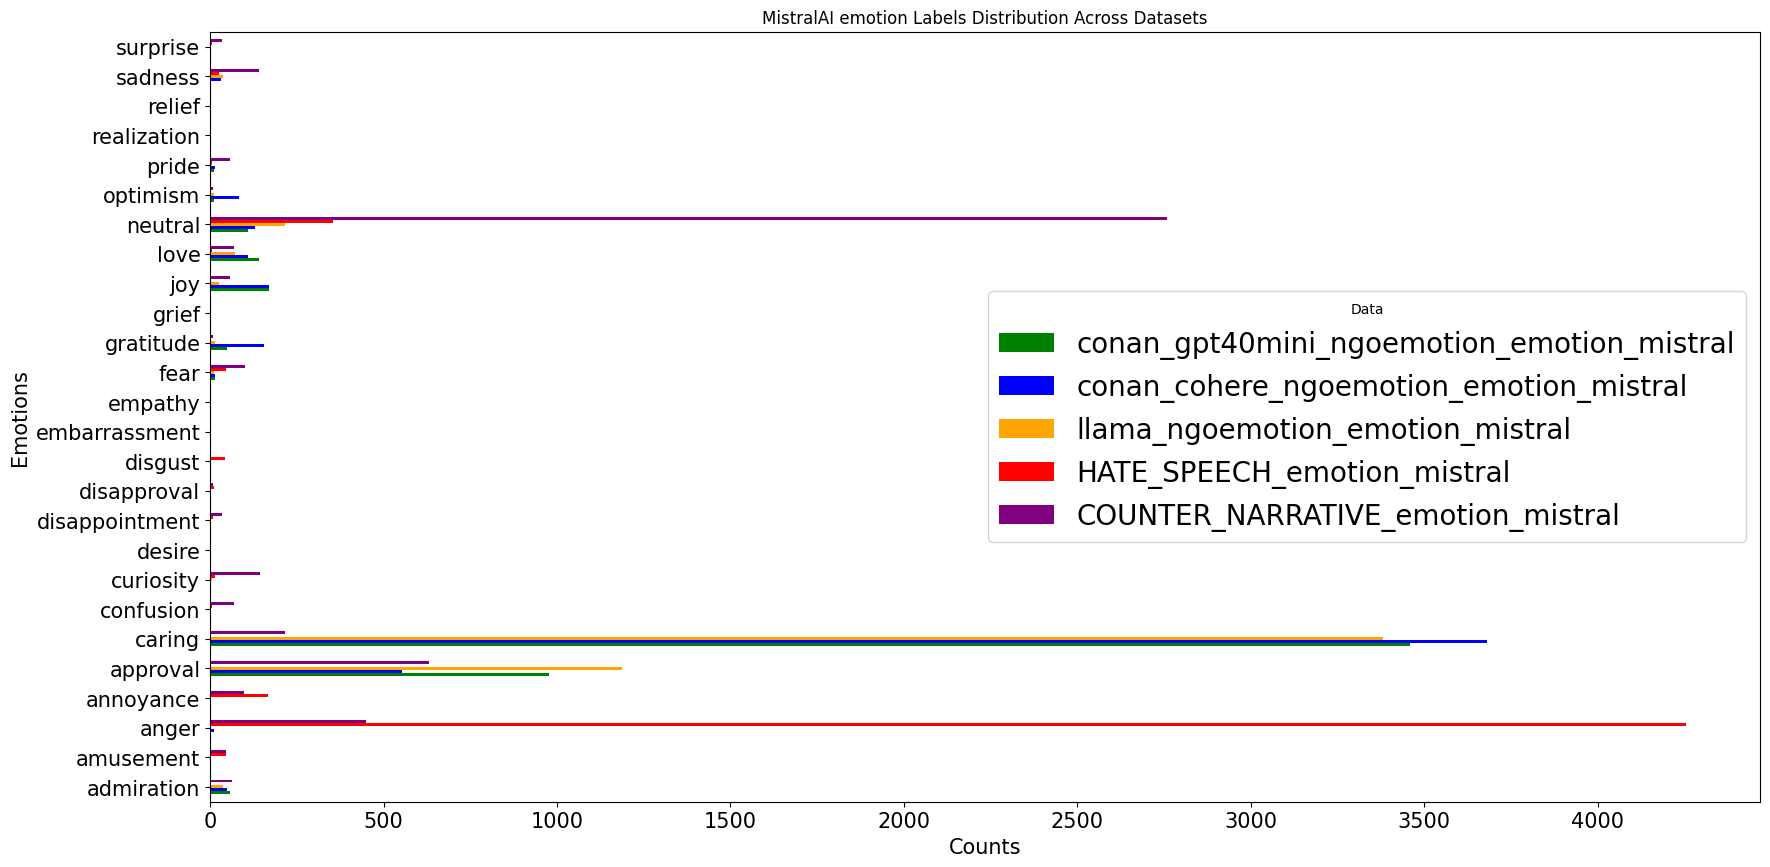

                                              negative  neutral  positive  \
conan_gpt40mini_ngoemotion_sentiment_mistral       4.0     31.0    4967.0   
conan_cohere_ngoemotion_sentiment_mistral         79.0    108.0    4786.0   
conan_llama70b_ngoemotion_sentiment_mistral       41.0     85.0    4875.0   
HATE_SPEECH_sentiment_mistral                    835.0    141.0      17.0   
COUNTER_NARRATIVE_sentiment_mistral             1037.0   2043.0    1657.0   

                                              very negative  very positive  
conan_gpt40mini_ngoemotion_sentiment_mistral            0.0            1.0  
conan_cohere_ngoemotion_sentiment_mistral              30.0            0.0  
conan_llama70b_ngoemotion_sentiment_mistral             2.0            0.0  
HATE_SPEECH_sentiment_mistral                        4010.0            0.0  
COUNTER_NARRATIVE_sentiment_mistral                   266.0            0.0  


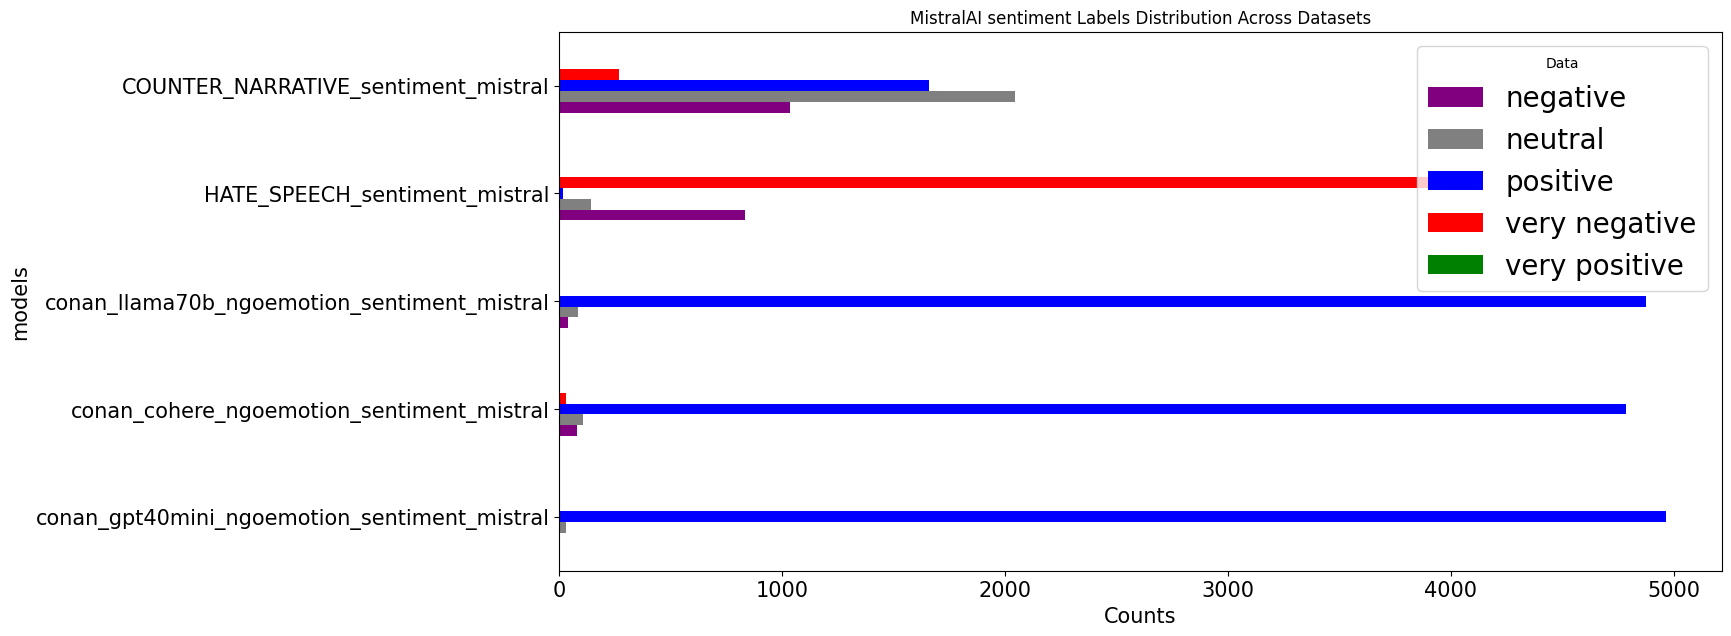


 plotting sankey charts conan-- ngoemotion



In [ ]:
import random
import pandas as pd
empathy_analysis = '/content/drive/MyDrive/PhD with Rawat/WOAH_2025/hateval/charts/march_25'
if __name__ == "__main__":
    emotion = BERTemotion()
    stats = Stats()
    sentiment = SentimentAnalyzer()
    conan_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/WOAH_2025/conan/nonan_conan_all_prompt_mistral_sent_emot.csv')

    dataset_cases = [('conan', conan_df)]
    models = ['gpt40mini', 'cohere', 'llama70b']
    personae = ['ngopersona', 'vanilla', 'ngoemotion']


    for persona in personae:
        for dataset_name, dataset in dataset_cases:
            print(f"\n\n\n\n +++++++++++++++++++ {dataset_name.upper()} - {persona.upper()} +++++++++++++++++++++++++\n\n\n\n")
            mistral_emotion_columns = [col for col in
                                       dataset.columns
                                       if persona in col
                                       and col.endswith('emotion_mistral')]+['HATE_SPEECH_emotion_mistral', 'COUNTER_NARRATIVE_emotion_mistral']
            mistral_sentiment_columns = [col for col in
                                         dataset.columns
                                         if persona in col
                                         and col.endswith('sentiment_mistral')] + ['HATE_SPEECH_sentiment_mistral', 'COUNTER_NARRATIVE_sentiment_mistral']
            print(f"\n plotting stats and emotions distribution for {dataset_name}-- {persona}\n")
            emotion.plot_emotion_distribution(dataset,
                                              emotion_columns=mistral_emotion_columns,
                                              model_name='MistralAI',
                                              image_name =f'mistral_{dataset_name}_emotion_distr_{dataset_name}_{persona}.png')
            # Plot sentiment distribution
            sentiment.plot_sentiment_distribution(dataset,
                                                  sentiment_columns=mistral_sentiment_columns,
                                                  model_name='MistralAI',
                                                  image_name="mistral_sentiment_results")

            print(f"\n plotting sankey charts {dataset_name}-- {persona}\n")
            for col in mistral_emotion_columns:
                    emotion.create_sankey_chart(
                        dataset[col], dataset_name, col.replace('_emotion_mistral', ''),
                        model_name='MistralAI', path=path
                    )

In [ ]:
originals  = ['HATE_SPEECH', 'COUNTER_NARRATIVE']

for item in originals:
  emotion.create_sankey_chart(ngoemotion_df[f"{item}_emotion"],
                                        'ngoemotion_df', item, model_name='RoBERTa',
                                        path=path)

In [ ]:
emotion = BERTemotion()
dataset_cases = [('conan', [('ngoemotion_df',ngoemotion_df)])] #('ngopersona_df',ngopersona_df),('ngoemotion_df',ngoemotion_df),[ ('vanilla_df',vanilla_df)]


models = ['gpt40mini', 'cohere', 'llama70b']
personae = [ 'ngoemotion' ]

for dataset_name, datasets in dataset_cases:
  for persona in personae:
    for name, dataset in datasets:
        print(f"\n\n\n\n +++++++++++++++++++ {name.upper()} +++++++++++++++++++++++++\n\n\n\n")
        expected_cols = [f'{dataset_name}_gpt40mini_{persona}_prompt',
                          f'{dataset_name}_cohere_{persona}_prompt',
                          f'{dataset_name}_llama70b_{persona}_prompt']
        col_names = [col for col in expected_cols if col in dataset.columns]
        print(col_names)
        emotion_columns = [col for col in dataset.columns if col.endswith('emotion')]
        print(emotion_columns)
        for col in col_names:
            emotion.create_sankey_chart(dataset[f"{col}_emotion"],
                                        dataset_name, col, model_name='RoBERTa',
                                        path=path)

Device set to use cpu






 +++++++++++++++++++ NGOEMOTION_DF +++++++++++++++++++++++++




['conan_gpt40mini_ngoemotion_prompt', 'conan_cohere_ngoemotion_prompt', 'conan_llama70b_ngoemotion_prompt']
['HATE_SPEECH_emotion', 'COUNTER_NARRATIVE_emotion', 'conan_gpt40mini_ngoemotion_prompt_emotion', 'conan_cohere_ngoemotion_prompt_emotion', 'conan_llama70b_ngoemotion_prompt_emotion']


In [ ]:
import pandas as pd
ngo_persona_emotion = ngoemotion_df[ngoemotion_df['conan_cohere_ngoemotion_prompt_emotion'] == 'gratitude']
ngo_persona_emotion = ngo_persona_emotion[['HATE_SPEECH', 'conan_cohere_ngoemotion_prompt', 'conan_cohere_ngoemotion_prompt_emotion']]
ngo_persona_emotion.shape

(1836, 3)

In [ ]:
ngo_persona_emotion.sample(30)

,HATE_SPEECH,conan_cohere_ngoemotion_prompt,conan_cohere_ngoemotion_prompt_emotion
14829,"Children should be raised by heterosexual parents, not gays. It is the best system ever.","Thank you for sharing your perspective. While I understand the intention behind your statement, I want to offer a different viewpoint. Every child deserves a loving and supportive family environment, regardless of the sexual orientation of their parents. The focus should be on ensuring children are raised in a nurturing and stable home, where they receive the love, care, and guidance they need to thrive. We can work together to create a society that embraces diversity and supports all famili...",gratitude
8238,"We allowed in thousands of people with serious mental illnesses, many of them from the Caucasus and the former Soviet Union. This is why mental health services are in crisis.","Thank you for sharing your concerns. It's important to acknowledge that the mental health system faces challenges, and addressing these issues requires a nuanced approach. Instead of focusing on blame, we should advocate for comprehensive mental health support that includes culturally sensitive care and community integration. Let's work together to build a system that supports all individuals, regardless of their background, and ensures access to the care they need.",gratitude
6175,"Equality is crap, even for woman. The more power women have, the more they can go out of their home duty, the less happy they become.","Thank you for sharing your perspective. It's important to recognize that equality is not a zero-sum game, and empowering women does not diminish the happiness of others. In fact, when women have more power and opportunities, they often contribute to positive social change, which can lead to a more harmonious and prosperous society for everyone.\n\nIt's understandable that change can be challenging and may require adjustments in traditional roles and mindsets. However, it's crucial to remembe...",gratitude
7317,"Children should be raised by heterosexual parents, not gays. It is the best system ever.","Thank you for sharing your perspective. While I understand the sentiment behind your statement, I want to offer a different viewpoint. Every child deserves a loving and supportive family environment, regardless of the sexual orientation of their parents. The well-being and happiness of children are paramount, and it is essential to recognize that same-sex couples can provide nurturing and stable homes. We must strive to create an inclusive society where all families are respected and valued,...",gratitude
5208,MIgrants are not running away from wars.,"Thank you for sharing your perspective. It's important to recognize that many migrants are indeed forced to leave their homes due to conflict, violence, and persecution. The decision to migrate is often a last resort, driven by the need to ensure the safety and well-being of oneself and one's loved ones. It is a challenging and courageous journey, and many migrants face immense risks and hardships along the way.\n\nHowever, it's crucial to remember that migration is a complex issue, and not ...",gratitude
712,Since when has abusing the anus as a sex organ been a ‘monumental achievement’? THIS IS STATE ENFORCED HOMOSEXUALITY! Maybe we should change our motto to ‘In Usury and Sodomy we trust (In reply to Botswana decriminalising homosexuality),"Thank you for sharing your concerns. It's important to acknowledge that the decriminalization of homosexuality in Botswana is a significant step towards protecting human rights and fostering a more inclusive society. However, we must also recognize that the language used in your comment, which equates same-sex relationships with ""state-enforced homosexuality"" and suggests a change in national motto, can be deeply offensive and harmful.\n\nIt's crucial to remember that hate speech, even when ...",gratitude
825,"Women are basically childlike, they remain this way most of thei

# REFUSAL AND IMPORTANCE RATES


 +++++++++++++++++++ CONAN_VANILLA +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_vanilla_prompt is approximately 0.000%
The refusal rate for conan_llama70b_vanilla_prompt is approximately 0.000%
The refusal rate for conan_cohere_vanilla_prompt is approximately 0.000%

 +++++++++++++++++++ CONAN_NGOPERSON +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_ngopersona_prompt is approximately 0.000%
The refusal rate for conan_llama70b_ngopersona_prompt is approximately 0.000%
The refusal rate for conan_cohere_ngopersona_prompt is approximately 0.000%

 +++++++++++++++++++ CONAN_NGOEMOTION +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_ngoemotion_prompt is approximately 0.000%
The refusal rate for conan_llama70b_ngoemotion_prompt is approximately 0.000%
The refusal rate for conan_cohere_ngoemotion_prompt is approximately 0.000%


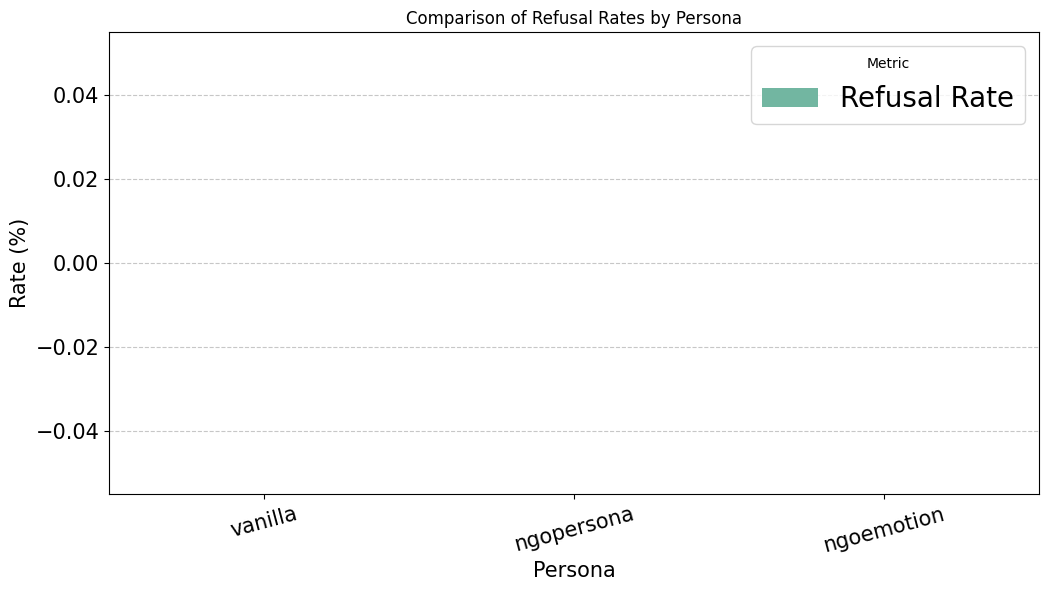


 +++++++++++++++++++ CONAN_VANILLA +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_vanilla_prompt is approximately 0.000%
The refusal rate for conan_llama70b_vanilla_prompt is approximately 0.000%
The refusal rate for conan_cohere_vanilla_prompt is approximately 0.000%

 +++++++++++++++++++ CONAN_NGOPERSON +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_ngopersona_prompt is approximately 0.000%
The refusal rate for conan_llama70b_ngopersona_prompt is approximately 0.000%
The refusal rate for conan_cohere_ngopersona_prompt is approximately 0.000%

 +++++++++++++++++++ CONAN_NGOEMOTION +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_ngoemotion_prompt is approximately 0.000%
The refusal rate for conan_llama70b_ngoemotion_prompt is approximately 0.000%
The refusal rate for conan_cohere_ngoemotion_prompt is approximately 0.000%


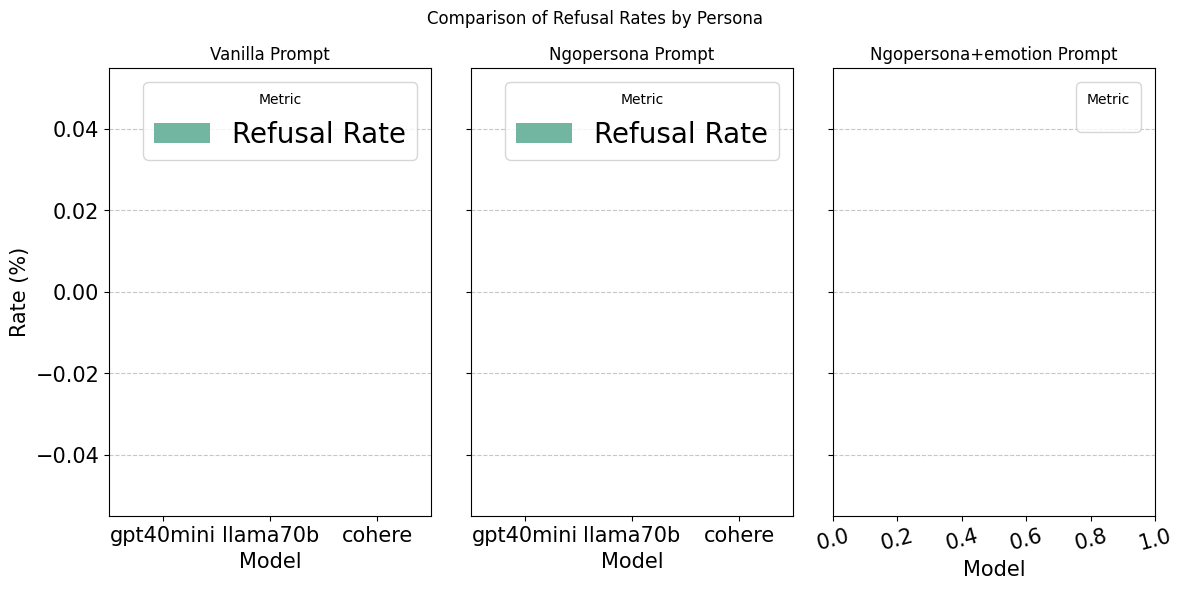


 +++++++++++++++++++ CONAN_VANILLA +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_vanilla_prompt is approximately 0.000%
The refusal rate for conan_llama70b_vanilla_prompt is approximately 0.000%
The refusal rate for conan_cohere_vanilla_prompt is approximately 0.000%

 +++++++++++++++++++ CONAN_NGOPERSON +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_ngopersona_prompt is approximately 0.000%
The refusal rate for conan_llama70b_ngopersona_prompt is approximately 0.000%
The refusal rate for conan_cohere_ngopersona_prompt is approximately 0.000%

 +++++++++++++++++++ CONAN_NGOEMOTION +++++++++++++++++++++++++

The refusal rate for conan_gpt40mini_ngoemotion_prompt is approximately 0.000%
The refusal rate for conan_llama70b_ngoemotion_prompt is approximately 0.000%
The refusal rate for conan_cohere_ngoemotion_prompt is approximately 0.000%


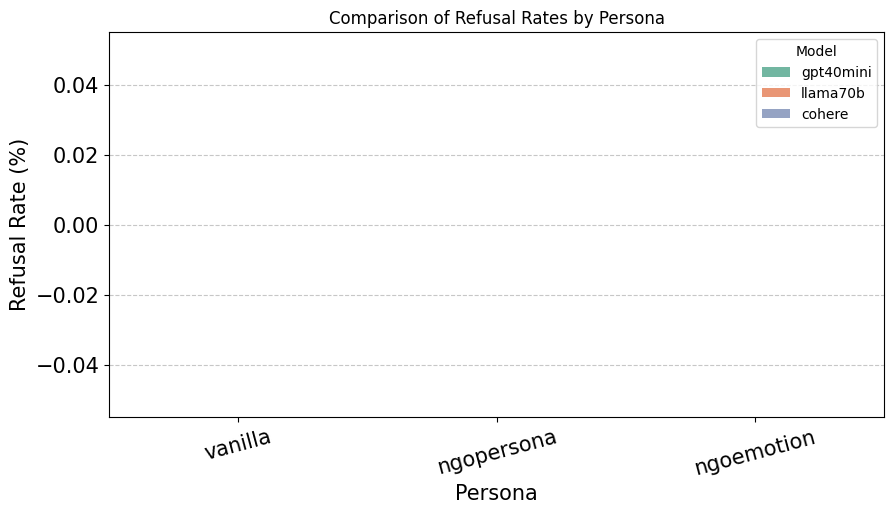

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500 # limit to the lenght of token that should be displayed on the daatsets
conan_ngoemotion = pd.read_csv('.../WOAH_2025/conan/charts/conan_ngoemotion_analysis_df.csv')
conan_ngoperson = pd.read_csv('.../WOAH_2025/conan/charts/conan_ngopersona_analysis_df.csv')
conan_vanilla = pd.read_csv('.../WOAH_2025/conan/charts/conan_vanilla_analysis_df.csv')

class RefusalImportance:

  def __init__(self):
    self.refusal_pattern = [
        r"\bI am an AI assistant\b",
        r"\bAs an? (AI|sophisticated AI|language model|chatbot|assistant),? I (cannot|will not|am not able to)\b",
        r"\bThis (is|falls) outside my (capabilities|abilities|training|ethical guidelines)\b",
        r"\bI (do not|cannot|will not) (condone|support) (hateful|offensive|harmful|discriminatory) content\b",
        r"\b(I'?m|I am|Sorry),? but I cannot (generate|provide|fulfill) a counter-narrative\b",
        r"\bI (am sorry|apologize),? but I cannot (fulfill|provide|generate) (your request|a counter-narrative)\b",
        r"\bI (am sorry|apologize),? but I cannot (fulfill|provide|generate) (your request|a counter-narrative)\b",
        r"\bI (am sorry|apologize),? but I cannot (support|amplify|condone|normalize|respond to|promote) (hateful|offensive|derogatory|discriminatory) (language|speech|content|comments)\b",
        r"\bI (am sorry|apologize),? but I cannot provide a counter-narrative that (includes|supports|condones|amplifies|promotes) (such|the use of) (hateful|offensive|derogatory|discriminatory) (language|speech|content|comments)\b",
        r"\bI (am sorry|apologize),? but I cannot generate a counter-narrative that (includes|condones|supports|responds to) (hate speech|offensive language|derogatory comments)\b",
        r"\bI understand that you want to respond to a hateful comment, but I cannot provide a counter-narrative that (includes|supports|condones|encourages|normalizes) (the use of|such) (profanity|explicit language|personal attacks|derogatory language|offensive language|hateful content)\b",
        r"\bI cannot provide a counter-narrative that (includes|supports|condones|encourages|normalizes) (the use of|such) (derogatory|offensive|hateful) (language|speech|content|comments|attacks)\b"
    ]

      # Function to detect refusals using regex
  def is_refusal_regex(self, response):
      if pd.isna(response) or not isinstance(response, str):
          return False
      return any(re.search(pattern, response.lower(),re.IGNORECASE) for pattern in self.refusal_pattern)

  def compute(self, datasets, personae, models):
    data_list = []
    for (dataset , dataset_name) in datasets:
        print(f"\n +++++++++++++++++++ {dataset_name.upper() } +++++++++++++++++++++++++\n")
        # for persona in personae:
        for model in models:
          for persona in personae:
                col = f'conan_{model}_{persona}_prompt'
                if col in dataset.columns:
                    #refusal
                    dataset[f'is_refusal_{col}'] = dataset[col].apply(self.is_refusal_regex)
                    refusal_count = dataset[f'is_refusal_{col}'].sum()
                    total_samples = len(dataset)
                    refusal_rate = (refusal_count / total_samples) * 100
                    data_list.append([dataset_name, model, persona, "Refusal Rate", refusal_rate])
                    print(f"The refusal rate for {col} is approximately {refusal_rate:.3f}%")

    return pd.DataFrame(data_list, columns=["Dataset", "Model", "Persona", "Metric", "Rate"])

  def plot_refusal_importance(self, datasets, personae, models, figsize = (12, 6)):
      df_rates = self.compute(datasets, personae, models)
      plt.figure(figsize=figsize)
      sns.barplot(data=df_rates, x="Persona", y="Rate", hue="Metric", palette="Set2")
      plt.title("Comparison of Refusal Rates by Persona")
      plt.xlabel("Persona")
      plt.ylabel("Rate (%)")
      plt.legend(title="Metric", fontsize="20")
      plt.xticks(rotation=15)
      plt.grid(axis="y", linestyle="--", alpha=0.7)
      plt.show()

  def plot_refusal_importance_3(self, datasets, personae, models, figsize=(10, 5)):
    df_rates = self.compute(datasets, personae, models)
    plt.figure(figsize=figsize)
    sns.barplot(data=df_rates, x="Persona", y="Rate", hue="Model", palette="Set2")
    plt.title("Comparison of Refusal Rates by Persona")
    plt.xlabel("Persona")
    plt.ylabel("Refusal Rate (%)")
    plt.legend(title="Model")
    plt.xticks(rotation=15)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

def main():
    refusal_importance = RefusalImportance()
    datasets = [
        (conan_vanilla, 'conan_vanilla'),
        (conan_ngoperson, 'conan_ngoperson'),
        (conan_ngoemotion, 'conan_ngoemotion')
    ]
    personae = ['vanilla', 'ngopersona', 'ngoemotion']
    models = ['gpt40mini', 'llama70b', 'cohere']
    refusal_importance.plot_refusal_importance(datasets, personae, models)
    refusal_importance.plot_refusal_importance_3(datasets, personae, models)
    return  datasets


if __name__ == "__main__":
     datasets = main()

# Assessing Emotions

In [ ]:
# emotion = BERTemotion()
conan_vanilla = pd.read_csv('.../WOAH_2025/conan/charts/conan_vanilla_analysis_df.csv')
def filter_by_emotion(emotion_dataset, main_column, emotion_label, column_of_interest):
    return emotion_dataset.loc[emotion_dataset[main_column] == emotion_label, column_of_interest].reset_index(drop=True)


datasets = ['conan']

for dataset in datasets:
    vanilla_emotions = conan_vanilla[['HATE_SPEECH', 'HATE_SPEECH_emotion',
                                          'COUNTER_NARRATIVE', 'COUNTER_NARRATIVE_emotion',
                                          f'{dataset}_cohere_vanilla_prompt', f'{dataset}_cohere_vanilla_prompt_emotion',
                                          f'{dataset}_gpt40mini_vanilla_prompt', f'{dataset}_gpt40mini_vanilla_prompt_emotion',
                                          f'{dataset}_llama70b_vanilla_prompt', f'{dataset}_llama70b_vanilla_prompt_emotion']]


    emotion_labels = 'amusement'#, 'admiration', 'neutral', 'annoyance', 'love', 'caring', 'admiration', 'joy']
    # column_of_interest = ['HATE_SPEECH', 'COUNTER_NARRATIVE', f'{dataset}_cohere_vanilla_prompt', f'{dataset}_cohere_vanilla_prompt_emotion']
    column_of_interest = ['HATE_SPEECH', 'HATE_SPEECH_emotion', 'COUNTER_NARRATIVE', 'COUNTER_NARRATIVE_emotion']
    admiration_cohere = filter_by_emotion(vanilla_emotions, 'HATE_SPEECH_emotion', emotion_labels, column_of_interest)
admiration_cohere

,HATE_SPEECH,HATE_SPEECH_emotion,COUNTER_NARRATIVE,COUNTER_NARRATIVE_emotion
0,"Makes me fucking laugh, why shouldn't whites be supreme in a mostly white country? How come nobody is moaning about black supremacy in black countries like Somalia? or Mexican supremacy? Or Indian supremacy? Only we put up with this fucking bullshit.",amusement,Why do we need supremacy? We are all created equal in the eyes of God.,curiosity
1,Pakistan: 202 Million Nigeria: 193 Million Bangladesh: 165 Million Ethiopia: 107 Million Congo: 84 Million Great Britain: 66 Million 'Ethnic minorities' Don’t make me fucking laugh!,amusement,"this is correct, but their percentage of the population within Great Britain makes them a minority",approval
2,Pakistan: 202 Million Nigeria: 193 Million Bangladesh: 165 Million Ethiopia: 107 Million Congo: 84 Million Great Britain: 66 Million 'Ethnic minorities' Don’t make me fucking laugh!,amusement,"These groups tend to be a minority in Britian. Either way, everyone deserves respect and protection and human rights.",approval
3,Pakistan: 202 Million Nigeria: 193 Million Bangladesh: 165 Million Ethiopia: 107 Million Congo: 84 Million Great Britain: 66 Million 'Ethnic minorities' Don’t make me fucking laugh!,amusement,"These are numbers of residents in countries, not ethnic grouping.",neutral
4,Pakistan: 202 Million Nigeria: 193 Million Bangladesh: 165 Million Ethiopia: 107 Million Congo: 84 Million Great Britain: 66 Million 'Ethnic minorities' Don’t make me fucking laugh!,amusement,Since when was Great Britain an ethnic group? Or Pakistan for that matter. Or Nigeria...etc,curiosity
5,"Makes me fucking laugh, why shouldn't whites be supreme in a mostly white country? How come nobody is moaning about black supremacy in black countries like Somalia? or Mexican supremacy? Or Indian supremacy? Only we put up with this fucking bullshit.",amusement,Perhaps the nations that you cite are more accepting of other nationalities.,neutral
6,"Makes me fucking laugh, why shouldn't whites be supreme in a mostly white country? How come nobody is moaning about black supremacy in black countries like Somalia? or Mexican supremacy? Or Indian supremacy? Only we put up with this fucking bullshit.",amusement,"maybe the roots of white supremacy deriving from centuries of mass colonisation, slavery and domination over others, are the reason that white supremacy is such a problem.",neutral
7,"Makes me fucking laugh, why shouldn't whites be supreme in a mostly white country? How come nobody is moaning about black supremacy in black countries like Somalia? or Mexican supremacy? Or Indian supremacy? Only we put up with this fucking bullshit.",amusement,I'm not moaning about diversity in the UK when I get a doctor from abroad who is highly competent and allows me to get better - in an NHS which is understaffed and underfunded.,neutral
8,"Makes me fucking laugh, why shouldn't whites be supreme in a mostly white country? How come nobody is moaning about black supremacy in black countries like Somalia? or Mexican supremacy? Or Indian supremacy? Only we put up with this fucking bullshit.",amusement,have you considered equality rather than supremacy? seems like a sensible option,curiosity
9,Pakistan: 202 Million Nigeria: 193 Million Bangladesh: 165 Million Ethiopia: 107 Million Congo: 84 Million Great Britain: 66 Million 'Ethnic minorities' Don’t make me fucking laugh!,amusement,"Ethnic minorities is a term used within a specific context, here for example, in the UK, people from these countries are minorities.",neutral


# Calculating the Meta Hate full ness sore for all the counter narratives

following >> https://arxiv.org/abs/2410.00775

In [ ]:
c
from google.colab import drive
drive.mount('/content/drive')

import os

empathy_analysis = '.../WOAH_2025/conan/charts/march_25/hate_scores'

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

empathy_analysis = '.../WOAH_2025/conan/charts/march_25/hate_scores'

ngopersona_df = pd.read_csv('.../WOAH_2025/conan/charts/march_25/conan_ngopersona_analysis_df.csv')
ngoemotion_df = pd.read_csv('.../WOAH_2025/conan/charts/march_25/conan_ngoemotion_analysis_df.csv')
vanilla_df = pd.read_csv('.../WOAH_2025/conan/charts/march_25/conan_vanilla_analysis_df.csv')

vanilla_prompt = [col for col in vanilla_df.columns if col.endswith('vanilla_prompt')]
ngopersona_prompt = [col for col in ngopersona_df.columns if col.endswith('ngopersona_prompt')]
ngoemotion_prompt = [col for col in ngoemotion_df.columns if col.endswith('ngoemotion_prompt')]

class Toxicity:
    def __init__ (self, max_length = 512, batch_size = 10, hate_model_name="irlab-udc/MetaHateBERT"): #"GroNLP/hateBERT"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(hate_model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(hate_model_name)
        self.model.eval()

    def get_hate_probability(self, text):
        inputs = self.tokenizer(text,
                              return_tensors="pt",
                              truncation=True,
                              padding=True,
                              max_length=self.max_length)
        with torch.no_grad():
            outputs = self.model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        hate_prob = probs[0][1].item()  # Probability of the "hateful" class
        return hate_prob
    def add_hate_scores_to_df(self, df, text_column):
        tqdm.pandas(desc=f"Processing {text_column}")
        df[f"{text_column}_hatescore"] = df[text_column].fillna("").progress_apply(self.get_hate_probability)
        return df

dataset_cases = [ ('ngoemotion', ngoemotion_df, ngoemotion_prompt )] #('vanilla', vanilla_df, vanilla_prompt),('ngopersona', ngopersona_df, ngopersona_prompt),

toxicity = Toxicity()
for dataset_name, dataset, persona_cols in tqdm(dataset_cases, desc="Processing Datasets"):
  for persona_col in tqdm(persona_cols, desc="Processing Persona Columns", leave=False):
    dataset = toxicity.add_hate_scores_to_df(dataset, persona_col)

  file_name = f'{dataset_name}_analysis_and_hatescores_df.csv'
  file_path = os.path.join(empathy_analysis, file_name)
  dataset.to_csv(file_path, index=False)
  print(f"Saved {dataset_name} dataset : {file_path}\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.

Processing conan_llama70b_ngoemotion_prompt:  10%|█         | 525/5003 [00:51<06:22, 11.70it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 527/5003 [00:51<06:10, 12.09it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 529/5003 [00:51<05:59, 12.43it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 531/5003 [00:51<05:50, 12.77it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 533/5003 [00:51<05:53, 12.64it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 535/5003 [00:52<06:11, 12.02it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 537/5003 [00:52<06:11, 12.03it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 539/5003 [00:52<06:15, 11.88it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 541/5003 [00:52<06:05, 12.20it/s]

Processing conan_llama70b_ngoemotion_prompt:  11%|█         | 543/5003 [00:

Saved ngoemotion dataset : /content/drive/MyDrive/PhD with Rawat/WOAH_2025/conan/charts/march_25/hate_scores/ngoemotion_analysis_and_hatescores_df.csv



# Assessing MetaHate scores

In [ ]:
import pandas as pd

hs_vanilla = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/vanilla_analysis_and_hatescores_df.csv')
hs_ngopersona = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/ngopersona_analysis_and_hatescores_df.csv')
hs_ngoemotion = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/ngoemotion_analysis_and_hatescores_df.csv')

hate_scores_vanilla = [col for col in hs_vanilla if col.endswith('hatescore')]
hate_scores_ngopersona = [col for col in hs_ngopersona if col.endswith('hatescore')]
hate_scores_ngoemotion = [col for col in hs_ngoemotion if col.endswith('hatescore')]
dataset_cases = [(hs_vanilla, hate_scores_vanilla), (hs_ngopersona,hate_scores_ngopersona), (hs_ngoemotion,hate_scores_ngoemotion)] #, (hs_ngopersona,hate_scores_ngopersona), (hs_ngoemotion,hate_scores_ngoemotion)

mean_scores_per_persona = {}
for dataset, hs_case in dataset_cases:
    for hate_score in hs_case:
      mean_scores_per_persona[hate_score] = dataset[hate_score].mean()*100

print(mean_scores_per_persona)

{'conan_gpt40mini_vanilla_prompt_hatescore': np.float64(2.99926402882218), 'conan_cohere_vanilla_prompt_hatescore': np.float64(5.607280566299783), 'conan_llama70b_vanilla_prompt_hatescore': np.float64(0.2006406391772604), 'conan_gpt40mini_ngopersona_prompt_hatescore': np.float64(3.0021716455449874), 'conan_cohere_ngopersona_prompt_hatescore': np.float64(4.785785966370779), 'conan_llama70b_ngopersona_prompt_hatescore': np.float64(0.17410268182871363), 'conan_gpt40mini_ngoemotion_prompt_hatescore': np.float64(1.482321543310437), 'conan_cohere_ngoemotion_prompt_hatescore': np.float64(2.2227601951623654), 'conan_llama70b_ngoemotion_prompt_hatescore': np.float64(0.12003466029087483)}


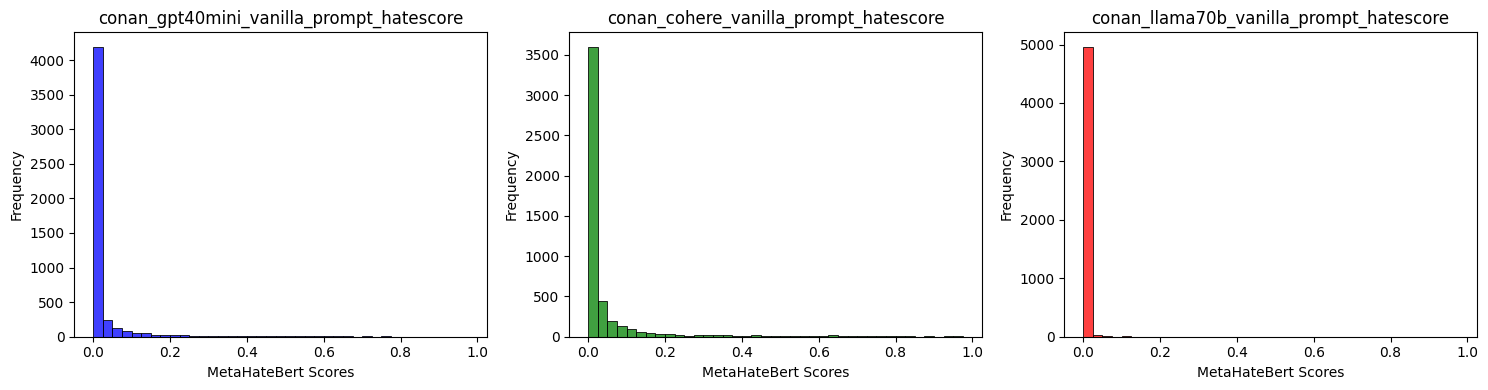

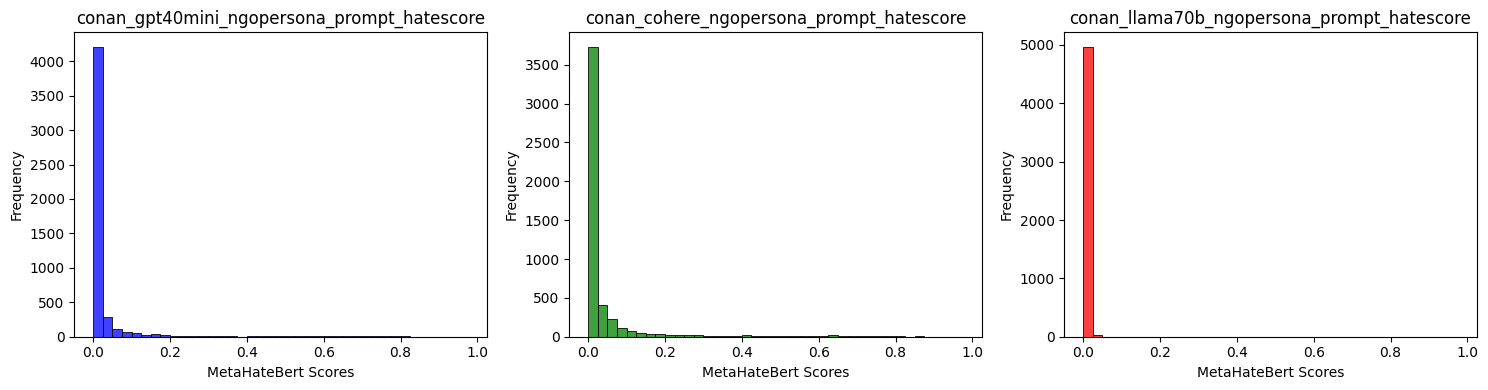

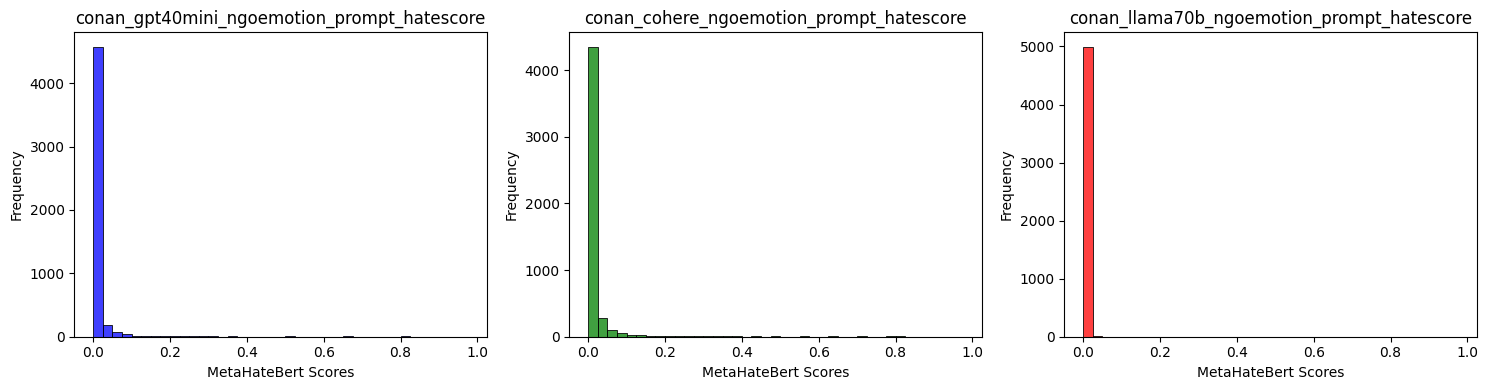

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_colwidth = 600

def plot_hs_histograms(df, col_gpt40mini, col_cohere, col_llama, image_name):
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 3, 1)
        sns.histplot(df[col_gpt40mini],
                     bins=np.arange(0, 1, 0.025),
                     color='blue')
        plt.xlabel('MetaHateBert Scores')
        plt.ylabel("Frequency")
        plt.title(f"{col_gpt40mini}")

        plt.subplot(1, 3, 2)
        sns.histplot(df[col_cohere],
                     bins=np.arange(0, 1, 0.025),
                     color='green')
        plt.xlabel('MetaHateBert Scores')
        plt.ylabel("Frequency")
        plt.title(f"{col_cohere}")

        plt.subplot(1, 3, 3)
        sns.histplot(df[col_llama],
                     bins=np.arange(0, 1, 0.025),
                     color='red')
        plt.xlabel('MetaHateBert Scores')
        plt.ylabel("Frequency")
        plt.title(f"{col_llama}")
        # plt.savefig(path/image_name)
        plt.tight_layout()
        plt.show()
for dataset, hs_case in dataset_cases:
    plot_hs_histograms(dataset,
                      hs_case[0],
                        hs_case[1],
                        hs_case[2],
                      'hate_score_distributions')

In [ ]:
vanilla_hate = hs_ngoemotion[hs_ngoemotion['conan_cohere_ngoemotion_prompt_hatescore']>=0.8]
chosen = vanilla_hate[['HATE_SPEECH', 'conan_cohere_ngoemotion_prompt', 'conan_cohere_ngoemotion_prompt_hatescore']]
chosen

,HATE_SPEECH,conan_cohere_ngoemotion_prompt,conan_cohere_ngoemotion_prompt_hatescore
1780,"If a woman does not want to be a homemaker, then she is unfeminine and a bitch.","We must reject the idea that a woman's worth is defined by her role in the home. Femininity is not tied to homemaking; it is a spectrum of traits and actions that can be expressed in countless ways. Every woman has the right to define her own identity and purpose, and that may not always include traditional domestic roles. Let's celebrate the diversity of women's aspirations and encourage each other to pursue our passions, whether it's in the kitchen, the boardroom, or the great outdoors. Together, we can create a society that values all women and their unique contributions.",0.802362
2908,Muslims have no place in a modern democracy like the UK.,"I understand your concerns, but it's important to remember that every individual, regardless of their background, deserves respect and the right to participate in a democratic society. The UK, with its rich history of diversity and inclusivity, has always been a place where people from all walks of life can contribute to its progress. Muslims, like any other community, have played and continue to play a vital role in shaping the UK's culture, economy, and political landscape. Excluding them would not only be discriminatory but also undermine the very principles of democracy. Let's embrace ...",0.916104
2987,"Feminism is just a bunch of mean, bitchy cuntwits trying to force their politically correct ideology on everyone else.","Thank you for sharing your perspective. I understand that you may have concerns about the impact of certain feminist movements. However, it's important to recognize that not all feminists are ""mean, bitchy cuntwits."" Feminism is a diverse movement with various branches, each advocating for different aspects of gender equality. It's a collective effort to challenge societal norms, address injustices, and promote the rights and empowerment of all women.\n\nWhile there may be instances of heated debates or disagreements within the feminist community, it is crucial to approach these discussion...",0.817364
3025,Jews are a problem in many European countries because of their race and religion.,"We must reject this hateful and dangerous rhetoric. Jews, like all people, deserve respect and equality. The idea that any group's race or religion makes them inherently problematic is a toxic and false notion that has led to countless atrocities throughout history. Let's instead focus on building bridges and understanding, where every individual is valued and respected, regardless of their background. We can create a more harmonious society by embracing diversity and promoting empathy.",0.823901
3110,Muslims have no place in civilised Europe. They are incompatible with modern culture and should be banished forever.,"We must reject the idea that any group, including Muslims, is inherently incompatible with modern European culture. Diversity is a strength, and every individual, regardless of faith, has a right to live with dignity and respect. Let's embrace our shared humanity and work together to build an inclusive society where everyone can thrive. We can achieve this through open dialogue, understanding, and support for one another.",0.831456
3138,"We are importing Muslim criminals, and they are all terrorists.","Importing Muslim criminals and equating them with terrorists is a dangerous and harmful generalization. It perpetuates harmful stereotypes and contributes to a climate of fear and suspicion. We must recognize that not all individuals from a particular religious or cultural background are criminals or terrorists. Instead, we should focus on addressing the root causes of crime and terrorism, which are often complex and multifaceted. Let's work towards building a society that values diversity, promotes understanding, and ensures justice for all.",0.826665
3537,Jews make too much money.,"We must rem

# Readability


In [ ]:
!pip install textstat tqdm

import pandas as pd
import textstat
import os

from tqdm import tqdm
pd.options.display.max_colwidth = 600

path = '/content/drive/MyDrive/PhD with Rawat/WOAH_2025/conan/charts/march_25/hate_scores'

hs_vanilla = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/vanilla_analysis_and_hatescores_df.csv')
hs_ngopersona = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/ngopersona_analysis_and_hatescores_df.csv')
hs_ngoemotion = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/ngoemotion_analysis_and_hatescores_df.csv')

datasets = [('vanilla', hs_vanilla), ('ngopersona', hs_ngopersona), ('ngoemotion', hs_ngoemotion)]

def add_readability_scores(df, column_name):
    df[f"flesch_ease_{column_name}"] = df[column_name].apply(textstat.flesch_reading_ease)
    df[f"fk_grade_{column_name}"] = df[column_name].apply(textstat.flesch_kincaid_grade)
    return df

for (dataset_name, dataset) in datasets:
  col_prompt = [col for col in dataset.columns if col.endswith('prompt')]
  for col_name in tqdm(col_prompt, desc=f"Processing {dataset_name}"):
    dataset = add_readability_scores(dataset, col_name)

  file_name = f'readability_measures_{dataset_name}_df.csv'
  file_path = os.path.join(path, file_name)
  dataset.to_csv(file_path, index=False)


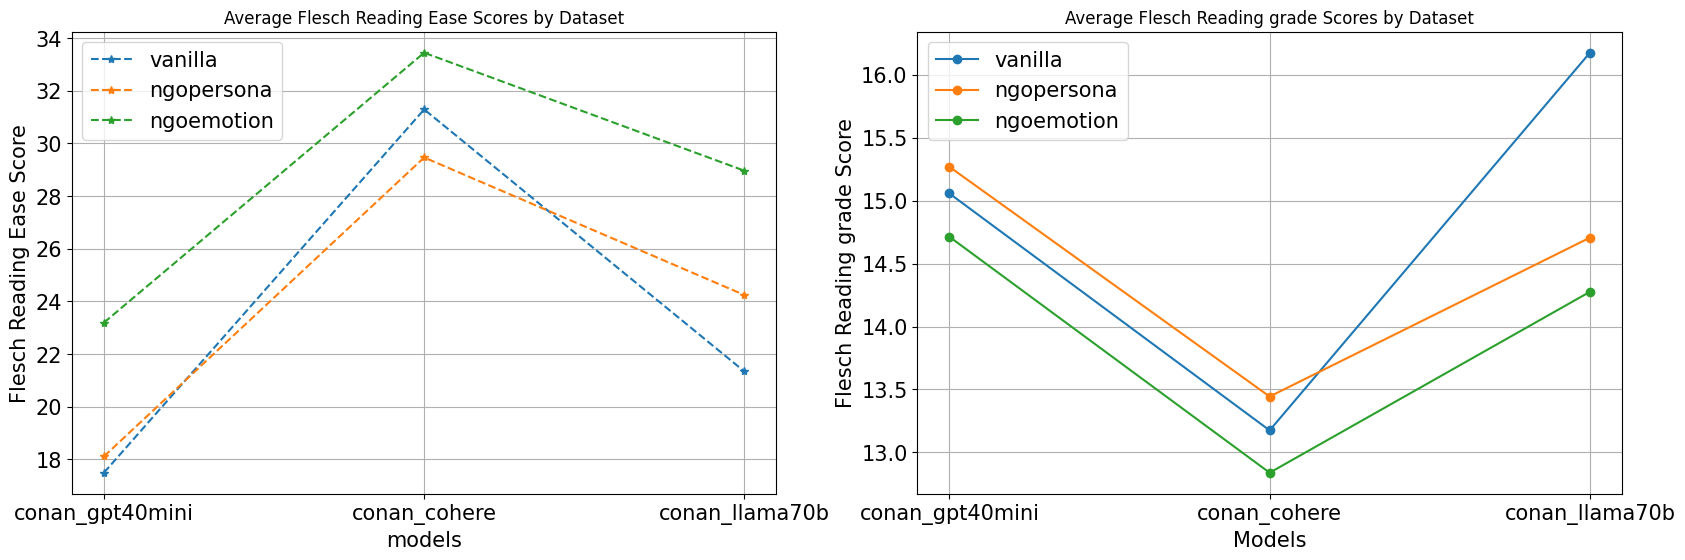

In [ ]:
ease_scores = {}
grade_scores = {}
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['axes.labelsize'] = 15 #set axis font size globally

read_vanilla = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/readability_measures_vanilla_df.csv')
read_ngopersona = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/readability_measures_ngopersona_df.csv')
read_ngoemotion = pd.read_csv('.../WOAH_2025/conan/charts/march_25/hate_scores/readability_measures_ngoemotion_df.csv')

datasets = [('vanilla', read_vanilla), ('ngopersona', read_ngopersona), ('ngoemotion', read_ngoemotion)]
colors = ['blue', 'orange', 'green']


for (dataset_name, dataset) in datasets:
  # print(f'\nworking on {dataset_name.upper()}\n')
  col_ease = [col for col in dataset.columns if col.startswith('flesch_ease')]
  ease_scores[dataset_name] = [dataset[col].mean() for col in col_ease]

  col_grade = [col for col in dataset.columns if col.startswith('fk_grade')]
  grade_scores[dataset_name] = [dataset[col].mean() for col in col_grade]

# For plotting ease scores
plt.figure(figsize=(20, 6))
prompt_names = [col.replace('flesch_ease_', '').replace('_ngoemotion_prompt', '') for col in col_ease]

plt.subplot(1, 2, 1)
for dataset_name, means in ease_scores.items():
    plt.plot(prompt_names, ease_scores[dataset_name], marker='*', linestyle = 'dashed', label=dataset_name)
plt.title('Average Flesch Reading Ease Scores by Dataset')
plt.xticks(rotation= 0)
plt.ylabel('Flesch Reading Ease Score')
plt.xlabel('models')
plt.grid(True)
plt.legend(fontsize = 15, loc='best')

plt.subplot(1, 2, 2)
for dataset_name, means in grade_scores.items():
    prompt_names = [col.replace('flesch_ease_', '').replace('_ngoemotion_prompt', '') for col in col_ease]
    plt.plot(prompt_names, grade_scores[dataset_name], marker='o', label=dataset_name)
plt.title('Average Flesch Reading grade Scores by Dataset')
plt.xticks(rotation= 0)
plt.ylabel('Flesch Reading grade Score')
plt.xlabel('Models')
plt.legend(fontsize = 15, loc='best')
plt.grid(True)
plt.show()

In [ ]:
def add_readability_scores(df, column_name):
    df[f"flesch_ease_{column_name}"] = df[column_name].apply(textstat.flesch_reading_ease)
    df[f"fk_grade_{column_name}"] = df[column_name].apply(textstat.flesch_kincaid_grade)
    return df
outcome_ease = add_readability_scores(read_vanilla, 'COUNTER_NARRATIVE')
counter_ease_scores = read_vanilla['flesch_ease_COUNTER_NARRATIVE'].mean()
counter_grade_scores = read_vanilla['fk_grade_COUNTER_NARRATIVE'].mean()

print(counter_ease_scores, counter_grade_scores) #59.627015790525675 8.659324405356786

# stop here for now